<a href="https://colab.research.google.com/github/ofyzero/projectApollo/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential,load_model
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

import imageio

# add matplotlib 
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import cv2
from google.colab.patches import cv2_imshow

!pip install --upgrade moviepy
from moviepy.editor import VideoFileClip
from skimage.transform import resize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
# Load training images
with open("/content/drive/MyDrive/Colab Notebooks/computer vision/train_imaged.p", "rb") as f:
    train_images = pickle.load(f)

# Load image labels
with open("/content/drive/MyDrive/Colab Notebooks/computer vision/image_labels_CNN.p", "rb" ) as f:
  labels = pickle.load(f)


In [70]:
# Converts data to numpy to able to feed NN
train_images = np.array(train_images)
labels = np.array(labels)

In [71]:
# Normalize data
labels = labels / 255

In [72]:
# Suffle and split data to training , validation 
train_images, labels = shuffle(train_images, labels)
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1)

In [55]:
X_train.shape , y_val.shape

((11487, 80, 160, 3), (1277, 80, 160, 1))

EDA

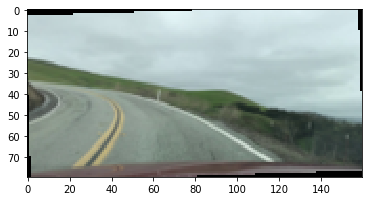

In [73]:
#display firsy image in trainig 
plt.imshow(X_train[0], interpolation='nearest')
plt.show()

In [78]:
#save frame
img = resize(X_train[0], (720, 1280, 3))
cv2.imwrite("frame.jpg",X_train[0])

True

Canny Edge Detection

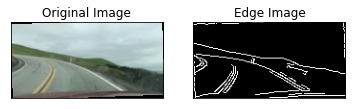

In [79]:
img = cv2.imread("frame.jpg")
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [83]:
def create_model(input_shape, pool_size):
    # Create the actual neural network
    model = Sequential()
    # Normalizes incoming inputs. First layer needs the input shape to work
    model.add(BatchNormalization(input_shape=input_shape))

    # Conv Layer 1
    model.add(Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))

    # Conv Layer 2
    model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))

    # Pooling 1
    model.add(MaxPooling2D(pool_size=pool_size))

    # Conv Layer 3
    model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))

    # Conv Layer 4
    model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))

    # Pooling 2
    model.add(MaxPooling2D(pool_size=pool_size))

    # Conv Layer 6
    model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))

    # Conv Layer 7
    model.add(Conv2D(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))

    # Pooling 3
    model.add(MaxPooling2D(pool_size=pool_size))

    # Upsample 1
    model.add(UpSampling2D(size=pool_size))

    # Deconv 1
    model.add(Conv2DTranspose(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))

    # Deconv 2
    model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))

    # Upsample 2
    model.add(UpSampling2D(size=pool_size))

    # Deconv 3
    model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))

    # Deconv 4
    model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))
    model.add(Dropout(0.2))

    # Upsample 3
    model.add(UpSampling2D(size=pool_size))

    # Deconv 6
    model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))

    # Final layer
    model.add(Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'relu'))

    return model


In [35]:
def display_model_training(history):
  # list all data in history
  print(history.history.keys())
 
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [85]:
batch_size = 128 # batch size 
epochs = 10 # epoch 
pool_size = (2, 2) # pool size 
input_shape = X_train.shape[1:] # input shape

In [86]:
# Create the neural network
model = create_model(input_shape, pool_size)

In [28]:
# Using a generator to help the model use less data
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)

In [33]:
# Compiling and training the model
model.compile(optimizer='Adam', loss='mean_squared_error')
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=len(X_train)/batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))

<ipython-input-33-57961aad98d9>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),


Epoch 1/10
89/89 [==============================] - 793s 9s/step - loss: 0.0511 - val_loss: 0.0222
Epoch 2/10
89/89 [==============================] - 833s 9s/step - loss: 0.0159 - val_loss: 0.0126
Epoch 3/10
89/89 [==============================] - 831s 9s/step - loss: 0.0120 - val_loss: 0.0099
Epoch 4/10
89/89 [==============================] - 810s 9s/step - loss: 0.0105 - val_loss: 0.0090
Epoch 5/10
89/89 [==============================] - 804s 9s/step - loss: 0.0096 - val_loss: 0.0083
Epoch 6/10
89/89 [==============================] - 794s 9s/step - loss: 0.0090 - val_loss: 0.0080
Epoch 7/10
89/89 [==============================] - 779s 9s/step - loss: 0.0086 - val_loss: 0.0081
Epoch 8/10
89/89 [==============================] - 784s 9s/step - loss: 0.0084 - val_loss: 0.0073
Epoch 9/10
89/89 [==============================] - 796s 9s/step - loss: 0.0082 - val_loss: 0.0077
Epoch 10/10
89/89 [==============================] - 818s 9s/step - loss: 0.0077 - val_loss: 0.0067


dict_keys(['loss', 'val_loss'])


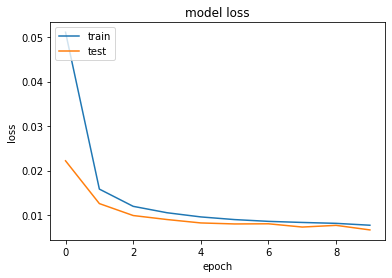

In [36]:
display_model_training(history)

In [37]:
# Freeze layers for using later
model.trainable = False
model.compile(optimizer='Adam', loss='mean_squared_error')

In [39]:
# Save model architecture and weights
model.save('/content/drive/MyDrive/Colab Notebooks/computer vision/line_detection_model.h5')

In [87]:
# Show summary of model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 80, 160, 3)       12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 78, 158, 8)        224       
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 156, 16)       1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 38, 78, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 76, 16)        2320      
                                                                 
 dropout (Dropout)           (None, 36, 76, 16)       

In [46]:
latest_fit = []
mean_fit = []

def predict_frame(image):
    """ Takes in a road image, re-sizes for the model,
    predicts the lane to be drawn from the model in G color,
    recreates an RGB image of a lane and merges with the
    original road image.
    """
    global latest_fit , mean_fit
    # resize images
    img = resize(image, (80, 160, 3))
    img = np.array(img)
    img = img[None,:,:,:]

    # predict frame and unnormalize
    prediction = model.predict(img)[0] * 255

    # add prediction to array 
    latest_fit.append(prediction)

    # latest 5 image are used for mean
    if len(latest_fit) > 5:
        latest_fit = latest_fit[1:]

    # calculate mean
    mean_fit = np.mean(np.array([i for i in latest_fit]), axis = 0)

    # print(len(mean_fit),len(latest_fit))
    # Generate fake R & B color dimensions, stack with G
    blanks = np.zeros_like(mean_fit.astype(np.uint8))
    lane_drawn = np.dstack((blanks, mean_fit, blanks))

    # Re-size to match the original image
    lane_image = resize(lane_drawn, (720, 1280, 3))

    # Merge the lane drawing onto the original image
    result = cv2.addWeighted(image, 1, lane_image, 1, 0,dtype=cv2.CV_32F)

    # cv2_imshow(result)
    return result

Getting prediction on 1 frame

In [36]:
# Where to save the output video
video_output = '/content/drive/MyDrive/Colab Notebooks/computer vision/output_video.mp4'
# Location of the input video
video_input = "/content/drive/MyDrive/Colab Notebooks/computer vision/test_video.mp4"

In [44]:
vidcap = cv2.VideoCapture(video_input)
success, image = vidcap.read()


1/1 [==============================] - 0s 69ms/step
80 5


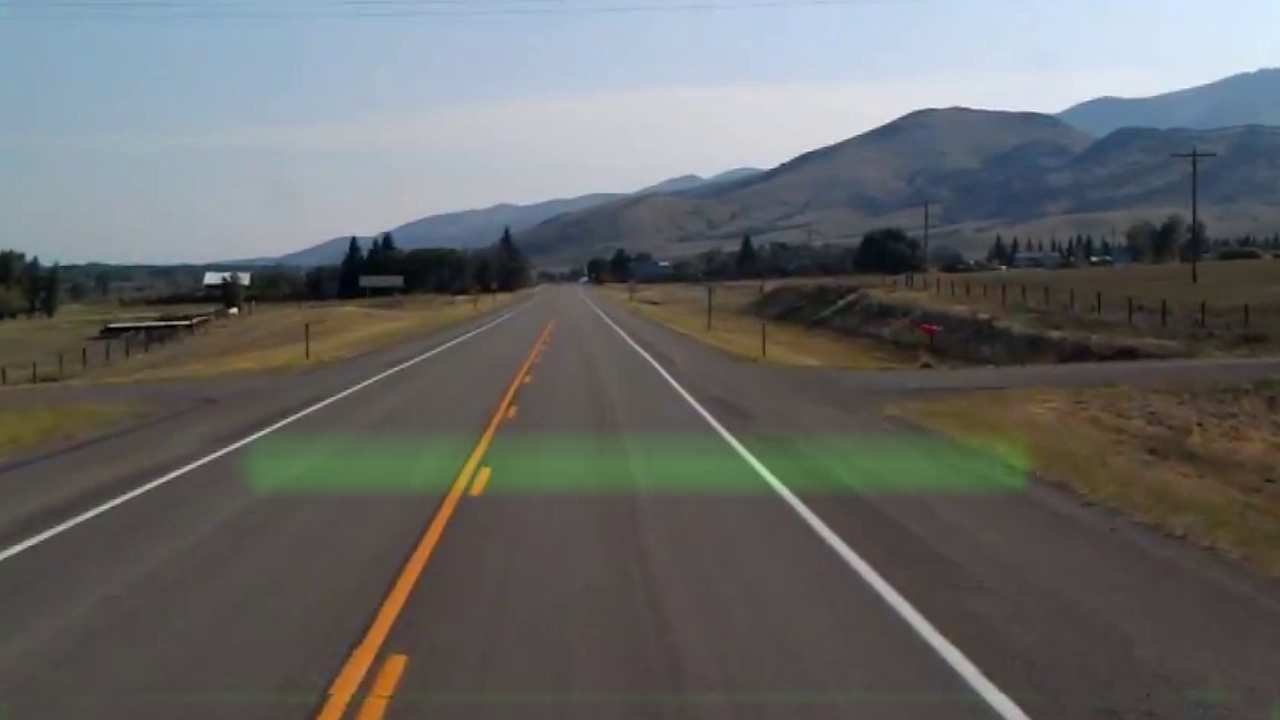

In [45]:
result = predict_frame(image)

In [47]:
# Load model
model = load_model('/content/drive/MyDrive/Colab Notebooks/computer vision/line_detection_model.h5')

# Create the clip
clip = VideoFileClip(video_input)

video_clip = clip.fl_image(predict_frame)
video_clip.write_videofile(video_output, audio=False)

1/1 [==============================] - 0s 289ms/step


























t:   0%|          | 6/1297 [04:26<17:01,  1.26it/s, now=None]



t:   3%|▎         | 38/1297 [04:10<09:07,  2.30it/s, now=None]

Moviepy - Building video /content/drive/MyDrive/Colab Notebooks/computer vision/output_video.mp4.







t:  51%|█████▏    | 665/1297 [1:12:56<05:01,  2.10it/s, now=None]

t:   6%|▌         | 76/1297 [48:34<20:18,  1.00it/s, now=None]





t:   3%|▎         | 40/1297 [01:20<20:38,  1.01it/s, now=None]























t:   0%|          | 6/1297 [04:26<17:01,  1.26it/s, now=None]



t:   3%|▎         | 38/1297 [04:10<09:07,  2.30it/s, now=None]




t:  51%|█████▏    | 665/1297 [1:12:56<05:01,  2.10it/s, now=None]

t:   6%|▌         | 76/1297 [48:34<20:18,  1.00it/s, now=None]





t:   3%|▎         | 40/1297 [01:20<20:38,  1.01it/s, now=None]

Moviepy - Writing video /content/drive/MyDrive/Colab Notebooks/computer vision/output_video.mp4










t:   0%|          | 0/1297 [00:00<?, ?it/s, now=None]

1/1 [==============================] - 0s 50ms/step









t:   0%|          | 2/1297 [00:00<04:32,  4.75it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:   0%|          | 3/1297 [00:00<06:41,  3.23it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:   0%|          | 4/1297 [00:01<07:51,  2.74it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:   0%|          | 5/1297 [00:01<08:12,  2.62it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:   0%|          | 6/1297 [00:02<08:21,  2.58it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:   1%|          | 7/1297 [00:02<08:50,  2.43it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:   1%|          | 8/1297 [00:03<08:54,  2.41it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:   1%|          | 9/1297 [00:03<09:02,  2.37it/s, now=None]

1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 51ms/step









t:   1%|          | 11/1297 [00:15<1:20:29,  3.76s/it, now=None]

1/1 [==============================] - 0s 64ms/step









t:   1%|          | 12/1297 [00:15<58:52,  2.75s/it, now=None]  

1/1 [==============================] - 0s 71ms/step









t:   1%|          | 13/1297 [00:16<43:51,  2.05s/it, now=None]

1/1 [==============================] - 0s 68ms/step









t:   1%|          | 14/1297 [00:16<33:21,  1.56s/it, now=None]

1/1 [==============================] - 0s 64ms/step









t:   1%|          | 15/1297 [00:16<26:01,  1.22s/it, now=None]

1/1 [==============================] - 0s 53ms/step









t:   1%|          | 16/1297 [00:17<20:48,  1.03it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:   1%|▏         | 17/1297 [00:17<17:19,  1.23it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:   1%|▏         | 18/1297 [00:18<14:49,  1.44it/s, now=None]

1/1 [==============================] - 0s 78ms/step









t:   1%|▏         | 19/1297 [00:18<13:06,  1.62it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:   2%|▏         | 20/1297 [00:19<11:47,  1.80it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:   2%|▏         | 21/1297 [00:19<10:54,  1.95it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:   2%|▏         | 22/1297 [00:19<10:19,  2.06it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:   2%|▏         | 23/1297 [00:20<09:59,  2.12it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:   2%|▏         | 24/1297 [00:20<09:44,  2.18it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:   2%|▏         | 25/1297 [00:21<09:22,  2.26it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:   2%|▏         | 26/1297 [00:21<09:18,  2.28it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:   2%|▏         | 27/1297 [00:22<09:25,  2.25it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:   2%|▏         | 28/1297 [00:22<09:23,  2.25it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:   2%|▏         | 29/1297 [00:22<09:15,  2.28it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:   2%|▏         | 30/1297 [00:23<09:08,  2.31it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:   2%|▏         | 31/1297 [00:23<09:04,  2.32it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:   2%|▏         | 32/1297 [00:24<09:05,  2.32it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:   3%|▎         | 33/1297 [00:24<09:07,  2.31it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:   3%|▎         | 34/1297 [00:25<09:11,  2.29it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:   3%|▎         | 35/1297 [00:25<09:03,  2.32it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:   3%|▎         | 36/1297 [00:25<09:10,  2.29it/s, now=None]

1/1 [==============================] - 0s 53ms/step









t:   3%|▎         | 37/1297 [00:26<09:17,  2.26it/s, now=None]

1/1 [==============================] - 0s 78ms/step









t:   3%|▎         | 38/1297 [00:26<09:10,  2.29it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:   3%|▎         | 39/1297 [00:27<09:02,  2.32it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:   3%|▎         | 40/1297 [00:27<08:55,  2.35it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:   3%|▎         | 41/1297 [00:28<09:02,  2.32it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:   3%|▎         | 42/1297 [00:28<08:58,  2.33it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:   3%|▎         | 43/1297 [00:28<08:59,  2.32it/s, now=None]

1/1 [==============================] - 0s 44ms/step









t:   3%|▎         | 44/1297 [00:29<09:43,  2.15it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:   3%|▎         | 45/1297 [00:29<09:34,  2.18it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:   4%|▎         | 46/1297 [00:30<09:21,  2.23it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:   4%|▎         | 47/1297 [00:30<09:18,  2.24it/s, now=None]

1/1 [==============================] - 0s 53ms/step









t:   4%|▎         | 48/1297 [00:31<09:30,  2.19it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:   4%|▍         | 49/1297 [00:31<09:36,  2.16it/s, now=None]

1/1 [==============================] - 0s 79ms/step









t:   4%|▍         | 50/1297 [00:32<09:42,  2.14it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:   4%|▍         | 51/1297 [00:32<09:34,  2.17it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:   4%|▍         | 52/1297 [00:33<09:36,  2.16it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:   4%|▍         | 53/1297 [00:33<09:50,  2.11it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:   4%|▍         | 54/1297 [00:34<09:38,  2.15it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:   4%|▍         | 55/1297 [00:34<09:31,  2.17it/s, now=None]

1/1 [==============================] - 0s 80ms/step









t:   4%|▍         | 56/1297 [00:35<09:27,  2.19it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:   4%|▍         | 57/1297 [00:35<09:55,  2.08it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:   4%|▍         | 58/1297 [00:36<09:46,  2.11it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:   5%|▍         | 59/1297 [00:36<09:34,  2.15it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:   5%|▍         | 60/1297 [00:36<09:23,  2.20it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:   5%|▍         | 61/1297 [00:37<09:46,  2.11it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:   5%|▍         | 62/1297 [00:37<09:44,  2.11it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:   5%|▍         | 63/1297 [00:38<09:36,  2.14it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:   5%|▍         | 64/1297 [00:38<09:21,  2.20it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:   5%|▌         | 65/1297 [00:39<09:39,  2.13it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:   5%|▌         | 66/1297 [00:39<09:38,  2.13it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:   5%|▌         | 67/1297 [00:40<09:26,  2.17it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:   5%|▌         | 68/1297 [00:40<09:23,  2.18it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:   5%|▌         | 69/1297 [00:41<09:12,  2.22it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:   5%|▌         | 70/1297 [00:41<09:31,  2.15it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:   5%|▌         | 71/1297 [00:41<09:16,  2.20it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:   6%|▌         | 72/1297 [00:42<09:17,  2.20it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:   6%|▌         | 73/1297 [00:42<09:31,  2.14it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:   6%|▌         | 74/1297 [00:43<09:16,  2.20it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:   6%|▌         | 75/1297 [00:43<09:14,  2.20it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:   6%|▌         | 76/1297 [00:44<09:10,  2.22it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:   6%|▌         | 77/1297 [00:44<09:38,  2.11it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:   6%|▌         | 78/1297 [00:45<09:27,  2.15it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:   6%|▌         | 79/1297 [00:45<09:10,  2.21it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:   6%|▌         | 80/1297 [00:46<09:10,  2.21it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:   6%|▌         | 81/1297 [00:46<09:36,  2.11it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:   6%|▋         | 82/1297 [00:47<09:27,  2.14it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:   6%|▋         | 83/1297 [00:47<09:18,  2.17it/s, now=None]

1/1 [==============================] - 0s 54ms/step









t:   6%|▋         | 84/1297 [00:47<09:13,  2.19it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:   7%|▋         | 85/1297 [00:48<09:28,  2.13it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:   7%|▋         | 86/1297 [00:48<09:25,  2.14it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:   7%|▋         | 87/1297 [00:49<09:17,  2.17it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:   7%|▋         | 88/1297 [00:49<09:03,  2.22it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:   7%|▋         | 89/1297 [00:50<09:23,  2.14it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:   7%|▋         | 90/1297 [00:50<09:29,  2.12it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:   7%|▋         | 91/1297 [00:51<09:20,  2.15it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:   7%|▋         | 92/1297 [00:51<09:21,  2.14it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:   7%|▋         | 93/1297 [00:52<09:25,  2.13it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:   7%|▋         | 94/1297 [00:52<09:20,  2.14it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:   7%|▋         | 95/1297 [00:53<09:16,  2.16it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:   7%|▋         | 96/1297 [00:53<09:01,  2.22it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:   7%|▋         | 97/1297 [00:54<09:25,  2.12it/s, now=None]

1/1 [==============================] - 0s 55ms/step









t:   8%|▊         | 98/1297 [00:54<09:14,  2.16it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:   8%|▊         | 99/1297 [00:54<09:22,  2.13it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:   8%|▊         | 100/1297 [00:55<09:14,  2.16it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:   8%|▊         | 101/1297 [00:55<09:34,  2.08it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:   8%|▊         | 102/1297 [00:56<09:29,  2.10it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:   8%|▊         | 103/1297 [00:56<09:25,  2.11it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:   8%|▊         | 104/1297 [00:57<09:12,  2.16it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:   8%|▊         | 105/1297 [00:57<09:25,  2.11it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:   8%|▊         | 106/1297 [00:58<09:29,  2.09it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:   8%|▊         | 107/1297 [00:58<09:13,  2.15it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:   8%|▊         | 108/1297 [00:59<09:03,  2.19it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:   8%|▊         | 109/1297 [00:59<09:26,  2.10it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:   8%|▊         | 110/1297 [01:00<09:27,  2.09it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:   9%|▊         | 111/1297 [01:00<09:17,  2.13it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:   9%|▊         | 112/1297 [01:01<09:04,  2.17it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:   9%|▊         | 113/1297 [01:01<09:15,  2.13it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:   9%|▉         | 114/1297 [01:02<09:13,  2.14it/s, now=None]

1/1 [==============================] - 0s 55ms/step









t:   9%|▉         | 115/1297 [01:02<09:05,  2.17it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:   9%|▉         | 116/1297 [01:02<08:54,  2.21it/s, now=None]

1/1 [==============================] - 0s 53ms/step









t:   9%|▉         | 117/1297 [01:03<09:10,  2.14it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:   9%|▉         | 118/1297 [01:03<09:15,  2.12it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:   9%|▉         | 119/1297 [01:04<09:12,  2.13it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:   9%|▉         | 120/1297 [01:04<09:01,  2.17it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:   9%|▉         | 121/1297 [01:05<09:14,  2.12it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:   9%|▉         | 122/1297 [01:05<09:13,  2.12it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:   9%|▉         | 123/1297 [01:06<09:08,  2.14it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  10%|▉         | 124/1297 [01:06<09:03,  2.16it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  10%|▉         | 125/1297 [01:07<09:17,  2.10it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  10%|▉         | 126/1297 [01:07<09:06,  2.14it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  10%|▉         | 127/1297 [01:08<09:00,  2.16it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  10%|▉         | 128/1297 [01:08<09:02,  2.15it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  10%|▉         | 129/1297 [01:09<09:01,  2.16it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  10%|█         | 130/1297 [01:09<08:53,  2.19it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  10%|█         | 131/1297 [01:09<08:50,  2.20it/s, now=None]

1/1 [==============================] - 0s 78ms/step









t:  10%|█         | 132/1297 [01:10<08:52,  2.19it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  10%|█         | 133/1297 [01:10<09:08,  2.12it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  10%|█         | 134/1297 [01:11<09:02,  2.14it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  10%|█         | 135/1297 [01:11<08:49,  2.19it/s, now=None]

1/1 [==============================] - 0s 54ms/step









t:  10%|█         | 136/1297 [01:12<08:40,  2.23it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  11%|█         | 137/1297 [01:12<09:11,  2.11it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  11%|█         | 138/1297 [01:13<09:07,  2.12it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  11%|█         | 139/1297 [01:13<09:02,  2.14it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  11%|█         | 140/1297 [01:14<08:48,  2.19it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  11%|█         | 141/1297 [01:14<09:04,  2.12it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  11%|█         | 142/1297 [01:15<08:59,  2.14it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  11%|█         | 143/1297 [01:15<08:56,  2.15it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  11%|█         | 144/1297 [01:15<08:39,  2.22it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  11%|█         | 145/1297 [01:16<08:55,  2.15it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  11%|█▏        | 146/1297 [01:16<09:04,  2.11it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  11%|█▏        | 147/1297 [01:17<08:51,  2.16it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  11%|█▏        | 148/1297 [01:17<08:47,  2.18it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  11%|█▏        | 149/1297 [01:18<08:55,  2.14it/s, now=None]

1/1 [==============================] - 0s 53ms/step









t:  12%|█▏        | 150/1297 [01:18<08:59,  2.13it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  12%|█▏        | 151/1297 [01:19<08:45,  2.18it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  12%|█▏        | 152/1297 [01:19<08:48,  2.17it/s, now=None]

1/1 [==============================] - 0s 89ms/step









t:  12%|█▏        | 153/1297 [01:20<09:40,  1.97it/s, now=None]

1/1 [==============================] - 0s 87ms/step









t:  12%|█▏        | 154/1297 [01:20<10:49,  1.76it/s, now=None]

1/1 [==============================] - 0s 112ms/step









t:  12%|█▏        | 155/1297 [01:21<11:54,  1.60it/s, now=None]

1/1 [==============================] - 0s 99ms/step









t:  12%|█▏        | 156/1297 [01:22<12:04,  1.58it/s, now=None]

1/1 [==============================] - 0s 125ms/step









t:  12%|█▏        | 157/1297 [01:23<12:52,  1.48it/s, now=None]

1/1 [==============================] - 0s 78ms/step









t:  12%|█▏        | 158/1297 [01:23<12:59,  1.46it/s, now=None]

1/1 [==============================] - 0s 92ms/step









t:  12%|█▏        | 159/1297 [01:24<13:04,  1.45it/s, now=None]

1/1 [==============================] - 0s 124ms/step









t:  12%|█▏        | 160/1297 [01:25<13:46,  1.38it/s, now=None]

1/1 [==============================] - 0s 118ms/step









t:  12%|█▏        | 161/1297 [01:26<13:54,  1.36it/s, now=None]

1/1 [==============================] - 0s 107ms/step









t:  12%|█▏        | 162/1297 [01:26<13:40,  1.38it/s, now=None]

1/1 [==============================] - 0s 85ms/step









t:  13%|█▎        | 163/1297 [01:27<13:29,  1.40it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:  13%|█▎        | 164/1297 [01:28<13:09,  1.44it/s, now=None]

1/1 [==============================] - 0s 141ms/step









t:  13%|█▎        | 165/1297 [01:29<13:59,  1.35it/s, now=None]

1/1 [==============================] - 0s 99ms/step









t:  13%|█▎        | 166/1297 [01:29<14:18,  1.32it/s, now=None]

1/1 [==============================] - 0s 155ms/step









t:  13%|█▎        | 167/1297 [01:30<14:11,  1.33it/s, now=None]

1/1 [==============================] - 0s 129ms/step









t:  13%|█▎        | 168/1297 [01:31<14:08,  1.33it/s, now=None]

1/1 [==============================] - 0s 97ms/step









t:  13%|█▎        | 169/1297 [01:32<13:43,  1.37it/s, now=None]

1/1 [==============================] - 0s 113ms/step









t:  13%|█▎        | 170/1297 [01:32<13:40,  1.37it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  13%|█▎        | 171/1297 [01:33<12:59,  1.44it/s, now=None]

1/1 [==============================] - 0s 115ms/step









t:  13%|█▎        | 172/1297 [01:34<13:01,  1.44it/s, now=None]

1/1 [==============================] - 0s 122ms/step









t:  13%|█▎        | 173/1297 [01:34<13:15,  1.41it/s, now=None]

1/1 [==============================] - 0s 111ms/step









t:  13%|█▎        | 174/1297 [01:35<13:17,  1.41it/s, now=None]

1/1 [==============================] - 0s 84ms/step









t:  13%|█▎        | 175/1297 [01:36<13:22,  1.40it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  14%|█▎        | 176/1297 [01:36<12:07,  1.54it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  14%|█▎        | 177/1297 [01:37<11:20,  1.65it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  14%|█▎        | 178/1297 [01:37<10:31,  1.77it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  14%|█▍        | 179/1297 [01:38<09:51,  1.89it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  14%|█▍        | 180/1297 [01:38<09:21,  1.99it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  14%|█▍        | 181/1297 [01:39<09:21,  1.99it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  14%|█▍        | 182/1297 [01:39<09:16,  2.00it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  14%|█▍        | 183/1297 [01:40<09:04,  2.05it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  14%|█▍        | 184/1297 [01:40<08:58,  2.07it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  14%|█▍        | 185/1297 [01:41<09:02,  2.05it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  14%|█▍        | 186/1297 [01:41<08:56,  2.07it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  14%|█▍        | 187/1297 [01:41<08:42,  2.12it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  14%|█▍        | 188/1297 [01:42<08:41,  2.13it/s, now=None]

1/1 [==============================] - 0s 79ms/step









t:  15%|█▍        | 189/1297 [01:42<09:04,  2.03it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  15%|█▍        | 190/1297 [01:43<08:58,  2.06it/s, now=None]

1/1 [==============================] - 0s 55ms/step









t:  15%|█▍        | 191/1297 [01:43<08:47,  2.10it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  15%|█▍        | 192/1297 [01:44<08:39,  2.13it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  15%|█▍        | 193/1297 [01:44<08:57,  2.05it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  15%|█▍        | 194/1297 [01:45<08:53,  2.07it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  15%|█▌        | 195/1297 [01:45<08:39,  2.12it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  15%|█▌        | 196/1297 [01:46<08:24,  2.18it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  15%|█▌        | 197/1297 [01:46<08:49,  2.08it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  15%|█▌        | 198/1297 [01:47<08:51,  2.07it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  15%|█▌        | 199/1297 [01:47<08:46,  2.09it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  15%|█▌        | 200/1297 [01:48<08:31,  2.15it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  15%|█▌        | 201/1297 [01:48<08:43,  2.09it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  16%|█▌        | 202/1297 [01:49<08:41,  2.10it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  16%|█▌        | 203/1297 [01:49<08:29,  2.15it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  16%|█▌        | 204/1297 [01:49<08:24,  2.17it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  16%|█▌        | 205/1297 [01:50<08:30,  2.14it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  16%|█▌        | 206/1297 [01:50<08:33,  2.12it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  16%|█▌        | 207/1297 [01:51<08:32,  2.13it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  16%|█▌        | 208/1297 [01:51<08:31,  2.13it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  16%|█▌        | 209/1297 [01:52<08:40,  2.09it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  16%|█▌        | 210/1297 [01:52<08:34,  2.11it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  16%|█▋        | 211/1297 [01:53<08:26,  2.15it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  16%|█▋        | 212/1297 [01:53<08:30,  2.13it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  16%|█▋        | 213/1297 [01:54<08:46,  2.06it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  16%|█▋        | 214/1297 [01:54<08:39,  2.08it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  17%|█▋        | 215/1297 [01:55<08:34,  2.10it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  17%|█▋        | 216/1297 [01:55<08:29,  2.12it/s, now=None]

1/1 [==============================] - 0s 79ms/step









t:  17%|█▋        | 217/1297 [01:56<08:54,  2.02it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  17%|█▋        | 218/1297 [01:56<08:50,  2.03it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  17%|█▋        | 219/1297 [01:57<08:32,  2.10it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  17%|█▋        | 220/1297 [01:57<08:35,  2.09it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  17%|█▋        | 221/1297 [01:58<08:43,  2.06it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  17%|█▋        | 222/1297 [01:58<08:44,  2.05it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  17%|█▋        | 223/1297 [01:59<08:30,  2.10it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  17%|█▋        | 224/1297 [01:59<08:29,  2.10it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  17%|█▋        | 225/1297 [02:00<08:35,  2.08it/s, now=None]

1/1 [==============================] - 0s 79ms/step









t:  17%|█▋        | 226/1297 [02:00<08:38,  2.06it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  18%|█▊        | 227/1297 [02:00<08:27,  2.11it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  18%|█▊        | 228/1297 [02:01<08:17,  2.15it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  18%|█▊        | 229/1297 [02:01<08:31,  2.09it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  18%|█▊        | 230/1297 [02:02<08:31,  2.09it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  18%|█▊        | 231/1297 [02:02<08:28,  2.10it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  18%|█▊        | 232/1297 [02:03<08:15,  2.15it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  18%|█▊        | 233/1297 [02:03<08:29,  2.09it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  18%|█▊        | 234/1297 [02:04<08:26,  2.10it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  18%|█▊        | 235/1297 [02:04<08:27,  2.09it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  18%|█▊        | 236/1297 [02:05<08:23,  2.11it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  18%|█▊        | 237/1297 [02:05<08:32,  2.07it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  18%|█▊        | 238/1297 [02:06<08:23,  2.10it/s, now=None]

1/1 [==============================] - 0s 92ms/step









t:  18%|█▊        | 239/1297 [02:06<08:25,  2.09it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  19%|█▊        | 240/1297 [02:07<08:17,  2.12it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  19%|█▊        | 241/1297 [02:07<08:29,  2.07it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  19%|█▊        | 242/1297 [02:08<08:21,  2.10it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  19%|█▊        | 243/1297 [02:08<08:17,  2.12it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  19%|█▉        | 244/1297 [02:09<08:14,  2.13it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  19%|█▉        | 245/1297 [02:09<08:27,  2.07it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  19%|█▉        | 246/1297 [02:10<08:22,  2.09it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  19%|█▉        | 247/1297 [02:10<08:10,  2.14it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  19%|█▉        | 248/1297 [02:10<08:08,  2.15it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  19%|█▉        | 249/1297 [02:11<08:22,  2.08it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  19%|█▉        | 250/1297 [02:11<08:20,  2.09it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  19%|█▉        | 251/1297 [02:12<08:05,  2.16it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  19%|█▉        | 252/1297 [02:12<07:59,  2.18it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  20%|█▉        | 253/1297 [02:13<08:15,  2.10it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  20%|█▉        | 254/1297 [02:13<08:24,  2.07it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  20%|█▉        | 255/1297 [02:14<08:09,  2.13it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  20%|█▉        | 256/1297 [02:14<07:56,  2.18it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  20%|█▉        | 257/1297 [02:15<08:26,  2.05it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  20%|█▉        | 258/1297 [02:15<08:23,  2.06it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  20%|█▉        | 259/1297 [02:16<08:17,  2.09it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  20%|██        | 260/1297 [02:16<08:08,  2.12it/s, now=None]

1/1 [==============================] - 0s 55ms/step









t:  20%|██        | 261/1297 [02:17<08:14,  2.09it/s, now=None]

1/1 [==============================] - 0s 80ms/step









t:  20%|██        | 262/1297 [02:17<08:14,  2.09it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  20%|██        | 263/1297 [02:18<08:11,  2.10it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  20%|██        | 264/1297 [02:18<08:02,  2.14it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  20%|██        | 265/1297 [02:19<08:15,  2.08it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  21%|██        | 266/1297 [02:19<08:16,  2.08it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  21%|██        | 267/1297 [02:19<08:07,  2.11it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  21%|██        | 268/1297 [02:20<07:56,  2.16it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  21%|██        | 269/1297 [02:20<08:14,  2.08it/s, now=None]

1/1 [==============================] - 0s 78ms/step









t:  21%|██        | 270/1297 [02:21<08:17,  2.06it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  21%|██        | 271/1297 [02:21<08:06,  2.11it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  21%|██        | 272/1297 [02:22<08:05,  2.11it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  21%|██        | 273/1297 [02:22<08:22,  2.04it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  21%|██        | 274/1297 [02:23<08:16,  2.06it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  21%|██        | 275/1297 [02:23<08:07,  2.09it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  21%|██▏       | 276/1297 [02:24<08:14,  2.06it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  21%|██▏       | 277/1297 [02:24<08:19,  2.04it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  21%|██▏       | 278/1297 [02:25<08:15,  2.06it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  22%|██▏       | 279/1297 [02:25<08:00,  2.12it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  22%|██▏       | 280/1297 [02:26<08:07,  2.09it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  22%|██▏       | 281/1297 [02:26<08:14,  2.06it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  22%|██▏       | 282/1297 [02:27<08:03,  2.10it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  22%|██▏       | 283/1297 [02:27<08:08,  2.08it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  22%|██▏       | 284/1297 [02:28<08:06,  2.08it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  22%|██▏       | 285/1297 [02:28<08:15,  2.04it/s, now=None]

1/1 [==============================] - 0s 55ms/step









t:  22%|██▏       | 286/1297 [02:29<08:05,  2.08it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  22%|██▏       | 287/1297 [02:29<07:59,  2.11it/s, now=None]

1/1 [==============================] - 0s 80ms/step









t:  22%|██▏       | 288/1297 [02:30<07:56,  2.12it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  22%|██▏       | 289/1297 [02:30<08:13,  2.04it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  22%|██▏       | 290/1297 [02:31<08:09,  2.06it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  22%|██▏       | 291/1297 [02:31<07:58,  2.10it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  23%|██▎       | 292/1297 [02:31<07:47,  2.15it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  23%|██▎       | 293/1297 [02:32<08:07,  2.06it/s, now=None]

1/1 [==============================] - 0s 47ms/step









t:  23%|██▎       | 294/1297 [02:33<08:23,  1.99it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  23%|██▎       | 295/1297 [02:33<08:13,  2.03it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  23%|██▎       | 296/1297 [02:33<07:58,  2.09it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  23%|██▎       | 297/1297 [02:34<07:50,  2.13it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  23%|██▎       | 298/1297 [02:34<07:52,  2.11it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  23%|██▎       | 299/1297 [02:35<07:53,  2.11it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  23%|██▎       | 300/1297 [02:35<07:50,  2.12it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  23%|██▎       | 301/1297 [02:36<07:41,  2.16it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  23%|██▎       | 302/1297 [02:36<07:41,  2.16it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:  23%|██▎       | 303/1297 [02:37<08:01,  2.07it/s, now=None]

1/1 [==============================] - 0s 81ms/step









t:  23%|██▎       | 304/1297 [02:37<08:00,  2.07it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  24%|██▎       | 305/1297 [02:38<07:48,  2.12it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  24%|██▎       | 306/1297 [02:38<07:45,  2.13it/s, now=None]

1/1 [==============================] - 0s 55ms/step









t:  24%|██▎       | 307/1297 [02:39<08:03,  2.05it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  24%|██▎       | 308/1297 [02:39<07:59,  2.06it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  24%|██▍       | 309/1297 [02:40<07:51,  2.10it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  24%|██▍       | 310/1297 [02:40<07:39,  2.15it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  24%|██▍       | 311/1297 [02:41<08:00,  2.05it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  24%|██▍       | 312/1297 [02:41<07:59,  2.05it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  24%|██▍       | 313/1297 [02:42<07:50,  2.09it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  24%|██▍       | 314/1297 [02:42<07:44,  2.12it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  24%|██▍       | 315/1297 [02:43<08:07,  2.01it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  24%|██▍       | 316/1297 [02:43<08:03,  2.03it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  24%|██▍       | 317/1297 [02:44<07:53,  2.07it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  25%|██▍       | 318/1297 [02:44<07:43,  2.11it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  25%|██▍       | 319/1297 [02:44<07:58,  2.05it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  25%|██▍       | 320/1297 [02:45<07:55,  2.06it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  25%|██▍       | 321/1297 [02:45<07:52,  2.07it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  25%|██▍       | 322/1297 [02:46<07:47,  2.09it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  25%|██▍       | 323/1297 [02:46<08:05,  2.01it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  25%|██▍       | 324/1297 [02:47<08:04,  2.01it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  25%|██▌       | 325/1297 [02:47<07:54,  2.05it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  25%|██▌       | 326/1297 [02:48<07:51,  2.06it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  25%|██▌       | 327/1297 [02:48<07:51,  2.06it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  25%|██▌       | 328/1297 [02:49<07:53,  2.05it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  25%|██▌       | 329/1297 [02:49<07:47,  2.07it/s, now=None]

1/1 [==============================] - 0s 53ms/step









t:  25%|██▌       | 330/1297 [02:50<07:34,  2.13it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  26%|██▌       | 331/1297 [02:50<07:45,  2.08it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  26%|██▌       | 332/1297 [02:51<07:42,  2.09it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  26%|██▌       | 333/1297 [02:51<07:37,  2.11it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  26%|██▌       | 334/1297 [02:52<07:32,  2.13it/s, now=None]

1/1 [==============================] - 0s 46ms/step









t:  26%|██▌       | 335/1297 [02:52<07:53,  2.03it/s, now=None]

1/1 [==============================] - 0s 78ms/step









t:  26%|██▌       | 336/1297 [02:53<07:51,  2.04it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  26%|██▌       | 337/1297 [02:53<07:38,  2.09it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  26%|██▌       | 338/1297 [02:54<07:39,  2.09it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  26%|██▌       | 339/1297 [02:54<07:46,  2.05it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  26%|██▌       | 340/1297 [02:55<07:40,  2.08it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  26%|██▋       | 341/1297 [02:55<07:30,  2.12it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  26%|██▋       | 342/1297 [02:56<07:27,  2.14it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  26%|██▋       | 343/1297 [02:56<07:47,  2.04it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  27%|██▋       | 344/1297 [02:57<07:45,  2.05it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  27%|██▋       | 345/1297 [02:57<07:34,  2.10it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  27%|██▋       | 346/1297 [02:57<07:33,  2.10it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  27%|██▋       | 347/1297 [02:58<07:51,  2.01it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  27%|██▋       | 348/1297 [02:59<07:53,  2.01it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  27%|██▋       | 349/1297 [02:59<07:49,  2.02it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  27%|██▋       | 350/1297 [02:59<07:32,  2.09it/s, now=None]

1/1 [==============================] - 0s 55ms/step









t:  27%|██▋       | 351/1297 [03:00<07:39,  2.06it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  27%|██▋       | 352/1297 [03:00<07:37,  2.07it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  27%|██▋       | 353/1297 [03:01<07:48,  2.01it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  27%|██▋       | 354/1297 [03:01<07:39,  2.05it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  27%|██▋       | 355/1297 [03:02<07:29,  2.10it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  27%|██▋       | 356/1297 [03:02<07:16,  2.16it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  28%|██▊       | 357/1297 [03:03<07:26,  2.10it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  28%|██▊       | 358/1297 [03:03<07:27,  2.10it/s, now=None]

1/1 [==============================] - 0s 54ms/step









t:  28%|██▊       | 359/1297 [03:04<07:18,  2.14it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  28%|██▊       | 360/1297 [03:04<07:12,  2.16it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  28%|██▊       | 361/1297 [03:05<07:24,  2.10it/s, now=None]

1/1 [==============================] - 0s 85ms/step









t:  28%|██▊       | 362/1297 [03:05<07:29,  2.08it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  28%|██▊       | 363/1297 [03:06<07:14,  2.15it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  28%|██▊       | 364/1297 [03:06<07:13,  2.15it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  28%|██▊       | 365/1297 [03:07<07:35,  2.05it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  28%|██▊       | 366/1297 [03:07<07:38,  2.03it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  28%|██▊       | 367/1297 [03:08<07:27,  2.08it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  28%|██▊       | 368/1297 [03:08<07:24,  2.09it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  28%|██▊       | 369/1297 [03:09<07:26,  2.08it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  29%|██▊       | 370/1297 [03:09<07:29,  2.06it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  29%|██▊       | 371/1297 [03:10<07:23,  2.09it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  29%|██▊       | 372/1297 [03:10<07:19,  2.10it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  29%|██▉       | 373/1297 [03:10<07:30,  2.05it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:  29%|██▉       | 374/1297 [03:11<07:27,  2.06it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  29%|██▉       | 375/1297 [03:11<07:24,  2.07it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:  29%|██▉       | 376/1297 [03:12<07:23,  2.08it/s, now=None]

1/1 [==============================] - 0s 80ms/step









t:  29%|██▉       | 377/1297 [03:12<07:30,  2.04it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  29%|██▉       | 378/1297 [03:13<07:22,  2.08it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  29%|██▉       | 379/1297 [03:13<07:19,  2.09it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  29%|██▉       | 380/1297 [03:14<07:18,  2.09it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  29%|██▉       | 381/1297 [03:14<07:34,  2.02it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  29%|██▉       | 382/1297 [03:15<07:22,  2.07it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  30%|██▉       | 383/1297 [03:15<07:10,  2.12it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  30%|██▉       | 384/1297 [03:16<07:14,  2.10it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  30%|██▉       | 385/1297 [03:16<07:26,  2.04it/s, now=None]

1/1 [==============================] - 0s 79ms/step









t:  30%|██▉       | 386/1297 [03:17<07:23,  2.06it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  30%|██▉       | 387/1297 [03:17<07:10,  2.11it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  30%|██▉       | 388/1297 [03:18<07:07,  2.13it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  30%|██▉       | 389/1297 [03:18<07:17,  2.07it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  30%|███       | 390/1297 [03:19<07:18,  2.07it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  30%|███       | 391/1297 [03:19<07:11,  2.10it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  30%|███       | 392/1297 [03:20<07:04,  2.13it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  30%|███       | 393/1297 [03:20<07:15,  2.08it/s, now=None]

1/1 [==============================] - 0s 83ms/step









t:  30%|███       | 394/1297 [03:21<07:17,  2.06it/s, now=None]

1/1 [==============================] - 0s 55ms/step









t:  30%|███       | 395/1297 [03:21<07:06,  2.11it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  31%|███       | 396/1297 [03:21<07:00,  2.14it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  31%|███       | 397/1297 [03:22<07:22,  2.04it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  31%|███       | 398/1297 [03:23<07:21,  2.03it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  31%|███       | 399/1297 [03:23<07:14,  2.07it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  31%|███       | 400/1297 [03:23<07:02,  2.12it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  31%|███       | 401/1297 [03:24<07:16,  2.05it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  31%|███       | 402/1297 [03:24<07:14,  2.06it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  31%|███       | 403/1297 [03:25<07:07,  2.09it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  31%|███       | 404/1297 [03:25<07:01,  2.12it/s, now=None]

1/1 [==============================] - 0s 48ms/step









t:  31%|███       | 405/1297 [03:26<07:16,  2.04it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  31%|███▏      | 406/1297 [03:26<07:14,  2.05it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  31%|███▏      | 407/1297 [03:27<07:13,  2.05it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  31%|███▏      | 408/1297 [03:27<07:09,  2.07it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  32%|███▏      | 409/1297 [03:28<07:16,  2.04it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  32%|███▏      | 410/1297 [03:28<07:17,  2.03it/s, now=None]

1/1 [==============================] - 0s 80ms/step









t:  32%|███▏      | 411/1297 [03:29<07:16,  2.03it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  32%|███▏      | 412/1297 [03:29<07:08,  2.06it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  32%|███▏      | 413/1297 [03:30<07:12,  2.04it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  32%|███▏      | 414/1297 [03:30<07:14,  2.03it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  32%|███▏      | 415/1297 [03:31<07:19,  2.01it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  32%|███▏      | 416/1297 [03:31<07:21,  2.00it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  32%|███▏      | 417/1297 [03:32<07:04,  2.07it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  32%|███▏      | 418/1297 [03:32<06:59,  2.10it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  32%|███▏      | 419/1297 [03:33<07:10,  2.04it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  32%|███▏      | 420/1297 [03:33<07:04,  2.06it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  32%|███▏      | 421/1297 [03:34<06:58,  2.10it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  33%|███▎      | 422/1297 [03:34<06:54,  2.11it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  33%|███▎      | 423/1297 [03:35<07:07,  2.04it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  33%|███▎      | 424/1297 [03:35<07:06,  2.05it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  33%|███▎      | 425/1297 [03:36<06:58,  2.08it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  33%|███▎      | 426/1297 [03:36<06:54,  2.10it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:  33%|███▎      | 427/1297 [03:37<07:09,  2.02it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  33%|███▎      | 428/1297 [03:37<07:04,  2.05it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  33%|███▎      | 429/1297 [03:38<06:58,  2.08it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  33%|███▎      | 430/1297 [03:38<06:53,  2.10it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  33%|███▎      | 431/1297 [03:39<07:04,  2.04it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  33%|███▎      | 432/1297 [03:39<07:02,  2.05it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  33%|███▎      | 433/1297 [03:39<06:56,  2.07it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  33%|███▎      | 434/1297 [03:40<06:52,  2.09it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  34%|███▎      | 435/1297 [03:40<06:58,  2.06it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  34%|███▎      | 436/1297 [03:41<06:57,  2.06it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  34%|███▎      | 437/1297 [03:41<06:55,  2.07it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  34%|███▍      | 438/1297 [03:42<06:50,  2.09it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  34%|███▍      | 439/1297 [03:42<06:58,  2.05it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  34%|███▍      | 440/1297 [03:43<06:52,  2.08it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  34%|███▍      | 441/1297 [03:43<06:51,  2.08it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  34%|███▍      | 442/1297 [03:44<06:47,  2.10it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  34%|███▍      | 443/1297 [03:44<06:58,  2.04it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  34%|███▍      | 444/1297 [03:45<06:54,  2.06it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  34%|███▍      | 445/1297 [03:45<06:48,  2.08it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  34%|███▍      | 446/1297 [03:46<06:51,  2.07it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  34%|███▍      | 447/1297 [03:46<06:57,  2.04it/s, now=None]

1/1 [==============================] - 0s 53ms/step









t:  35%|███▍      | 448/1297 [03:47<06:54,  2.05it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  35%|███▍      | 449/1297 [03:47<06:50,  2.07it/s, now=None]

1/1 [==============================] - 0s 54ms/step









t:  35%|███▍      | 450/1297 [03:48<06:48,  2.07it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  35%|███▍      | 451/1297 [03:48<07:03,  2.00it/s, now=None]

1/1 [==============================] - 0s 51ms/step









t:  35%|███▍      | 452/1297 [03:49<06:59,  2.01it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  35%|███▍      | 453/1297 [03:49<06:45,  2.08it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  35%|███▌      | 454/1297 [03:50<06:39,  2.11it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  35%|███▌      | 455/1297 [03:50<06:48,  2.06it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  35%|███▌      | 456/1297 [03:51<06:45,  2.07it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  35%|███▌      | 457/1297 [03:51<06:39,  2.10it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  35%|███▌      | 458/1297 [03:52<06:33,  2.13it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  35%|███▌      | 459/1297 [03:52<06:51,  2.04it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  35%|███▌      | 460/1297 [03:53<06:52,  2.03it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  36%|███▌      | 461/1297 [03:53<06:56,  2.01it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  36%|███▌      | 462/1297 [03:54<06:43,  2.07it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  36%|███▌      | 463/1297 [03:54<06:51,  2.03it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  36%|███▌      | 464/1297 [03:55<06:50,  2.03it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  36%|███▌      | 465/1297 [03:55<06:47,  2.04it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  36%|███▌      | 466/1297 [03:55<06:38,  2.09it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  36%|███▌      | 467/1297 [03:56<07:00,  1.98it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  36%|███▌      | 468/1297 [03:57<06:44,  2.05it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  36%|███▌      | 469/1297 [03:57<06:45,  2.04it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  36%|███▌      | 470/1297 [03:57<06:35,  2.09it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  36%|███▋      | 471/1297 [03:58<06:44,  2.04it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  36%|███▋      | 472/1297 [03:58<06:49,  2.02it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  36%|███▋      | 473/1297 [03:59<06:47,  2.02it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  37%|███▋      | 474/1297 [03:59<06:36,  2.07it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  37%|███▋      | 475/1297 [04:00<06:46,  2.02it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  37%|███▋      | 476/1297 [04:00<06:46,  2.02it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  37%|███▋      | 477/1297 [04:01<06:43,  2.03it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  37%|███▋      | 478/1297 [04:01<06:39,  2.05it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  37%|███▋      | 479/1297 [04:02<06:48,  2.00it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  37%|███▋      | 480/1297 [04:02<06:46,  2.01it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  37%|███▋      | 481/1297 [04:03<06:39,  2.04it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  37%|███▋      | 482/1297 [04:03<06:36,  2.06it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  37%|███▋      | 483/1297 [04:04<06:46,  2.00it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  37%|███▋      | 484/1297 [04:04<06:40,  2.03it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  37%|███▋      | 485/1297 [04:05<06:33,  2.06it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  37%|███▋      | 486/1297 [04:05<06:29,  2.08it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  38%|███▊      | 487/1297 [04:06<06:42,  2.01it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  38%|███▊      | 488/1297 [04:06<06:39,  2.03it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  38%|███▊      | 489/1297 [04:07<06:27,  2.08it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  38%|███▊      | 490/1297 [04:07<06:24,  2.10it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  38%|███▊      | 491/1297 [04:08<06:29,  2.07it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  38%|███▊      | 492/1297 [04:08<06:33,  2.05it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  38%|███▊      | 493/1297 [04:09<06:21,  2.11it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  38%|███▊      | 494/1297 [04:09<06:13,  2.15it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  38%|███▊      | 495/1297 [04:10<06:27,  2.07it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  38%|███▊      | 496/1297 [04:10<06:26,  2.08it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  38%|███▊      | 497/1297 [04:11<06:23,  2.09it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  38%|███▊      | 498/1297 [04:11<06:17,  2.11it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  38%|███▊      | 499/1297 [04:12<06:31,  2.04it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  39%|███▊      | 500/1297 [04:12<06:28,  2.05it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  39%|███▊      | 501/1297 [04:13<06:21,  2.09it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  39%|███▊      | 502/1297 [04:13<06:17,  2.11it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  39%|███▉      | 503/1297 [04:14<06:29,  2.04it/s, now=None]

1/1 [==============================] - 0s 84ms/step









t:  39%|███▉      | 504/1297 [04:14<06:34,  2.01it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  39%|███▉      | 505/1297 [04:15<06:34,  2.01it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  39%|███▉      | 506/1297 [04:15<06:30,  2.03it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  39%|███▉      | 507/1297 [04:16<06:36,  1.99it/s, now=None]

1/1 [==============================] - 0s 55ms/step









t:  39%|███▉      | 508/1297 [04:16<06:29,  2.03it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  39%|███▉      | 509/1297 [04:17<06:25,  2.04it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  39%|███▉      | 510/1297 [04:17<06:20,  2.07it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  39%|███▉      | 511/1297 [04:17<06:23,  2.05it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  39%|███▉      | 512/1297 [04:18<06:23,  2.05it/s, now=None]

1/1 [==============================] - 0s 54ms/step









t:  40%|███▉      | 513/1297 [04:18<06:17,  2.08it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  40%|███▉      | 514/1297 [04:19<06:16,  2.08it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  40%|███▉      | 515/1297 [04:19<06:26,  2.02it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  40%|███▉      | 516/1297 [04:20<06:25,  2.03it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  40%|███▉      | 517/1297 [04:20<06:21,  2.04it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  40%|███▉      | 518/1297 [04:21<06:13,  2.08it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  40%|████      | 519/1297 [04:21<06:25,  2.02it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  40%|████      | 520/1297 [04:22<06:29,  2.00it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  40%|████      | 521/1297 [04:22<06:17,  2.06it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  40%|████      | 522/1297 [04:23<06:13,  2.07it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  40%|████      | 523/1297 [04:23<06:19,  2.04it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  40%|████      | 524/1297 [04:24<06:18,  2.04it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  40%|████      | 525/1297 [04:24<06:11,  2.08it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  41%|████      | 526/1297 [04:25<06:08,  2.09it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  41%|████      | 527/1297 [04:25<06:26,  1.99it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  41%|████      | 528/1297 [04:26<06:14,  2.05it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  41%|████      | 529/1297 [04:26<06:08,  2.08it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  41%|████      | 530/1297 [04:27<06:03,  2.11it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  41%|████      | 531/1297 [04:27<06:17,  2.03it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  41%|████      | 532/1297 [04:28<06:17,  2.03it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  41%|████      | 533/1297 [04:28<06:09,  2.07it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  41%|████      | 534/1297 [04:29<06:03,  2.10it/s, now=None]

1/1 [==============================] - 0s 82ms/step









t:  41%|████      | 535/1297 [04:29<06:20,  2.00it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  41%|████▏     | 536/1297 [04:30<06:14,  2.03it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  41%|████▏     | 537/1297 [04:30<06:08,  2.06it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  41%|████▏     | 538/1297 [04:31<06:05,  2.08it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  42%|████▏     | 539/1297 [04:31<06:16,  2.01it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  42%|████▏     | 540/1297 [04:32<06:12,  2.03it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  42%|████▏     | 541/1297 [04:32<06:07,  2.06it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  42%|████▏     | 542/1297 [04:33<06:01,  2.09it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  42%|████▏     | 543/1297 [04:33<06:14,  2.02it/s, now=None]

1/1 [==============================] - 0s 44ms/step









t:  42%|████▏     | 544/1297 [04:34<06:24,  1.96it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  42%|████▏     | 545/1297 [04:34<06:14,  2.01it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  42%|████▏     | 546/1297 [04:35<06:03,  2.07it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  42%|████▏     | 547/1297 [04:35<06:06,  2.05it/s, now=None]

1/1 [==============================] - 0s 54ms/step









t:  42%|████▏     | 548/1297 [04:36<06:05,  2.05it/s, now=None]

1/1 [==============================] - 0s 54ms/step









t:  42%|████▏     | 549/1297 [04:36<06:08,  2.03it/s, now=None]

1/1 [==============================] - 0s 54ms/step









t:  42%|████▏     | 550/1297 [04:37<06:04,  2.05it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  42%|████▏     | 551/1297 [04:37<05:57,  2.09it/s, now=None]

1/1 [==============================] - 0s 54ms/step









t:  43%|████▎     | 552/1297 [04:37<05:54,  2.10it/s, now=None]

1/1 [==============================] - 0s 84ms/step









t:  43%|████▎     | 553/1297 [04:38<06:02,  2.05it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  43%|████▎     | 554/1297 [04:38<06:03,  2.05it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  43%|████▎     | 555/1297 [04:39<05:52,  2.10it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  43%|████▎     | 556/1297 [04:39<05:52,  2.10it/s, now=None]

1/1 [==============================] - 0s 55ms/step









t:  43%|████▎     | 557/1297 [04:40<06:01,  2.05it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  43%|████▎     | 558/1297 [04:40<06:03,  2.03it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  43%|████▎     | 559/1297 [04:41<06:02,  2.04it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  43%|████▎     | 560/1297 [04:41<05:51,  2.10it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  43%|████▎     | 561/1297 [04:42<06:02,  2.03it/s, now=None]

1/1 [==============================] - 0s 54ms/step









t:  43%|████▎     | 562/1297 [04:42<06:00,  2.04it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  43%|████▎     | 563/1297 [04:43<05:57,  2.05it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  43%|████▎     | 564/1297 [04:43<05:51,  2.08it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  44%|████▎     | 565/1297 [04:44<06:01,  2.02it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  44%|████▎     | 566/1297 [04:44<06:00,  2.03it/s, now=None]

1/1 [==============================] - 0s 51ms/step









t:  44%|████▎     | 567/1297 [04:45<06:09,  1.98it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  44%|████▍     | 568/1297 [04:45<06:03,  2.01it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  44%|████▍     | 569/1297 [04:46<05:59,  2.02it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  44%|████▍     | 570/1297 [04:46<05:52,  2.06it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  44%|████▍     | 571/1297 [04:47<05:48,  2.08it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  44%|████▍     | 572/1297 [04:47<05:58,  2.02it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  44%|████▍     | 573/1297 [04:48<05:52,  2.06it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  44%|████▍     | 574/1297 [04:48<05:46,  2.09it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  44%|████▍     | 575/1297 [04:49<05:50,  2.06it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  44%|████▍     | 576/1297 [04:49<05:56,  2.02it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  44%|████▍     | 577/1297 [04:50<06:00,  2.00it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  45%|████▍     | 578/1297 [04:50<05:51,  2.04it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  45%|████▍     | 579/1297 [04:51<05:46,  2.07it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  45%|████▍     | 580/1297 [04:51<05:55,  2.02it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  45%|████▍     | 581/1297 [04:52<05:54,  2.02it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  45%|████▍     | 582/1297 [04:52<05:46,  2.06it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  45%|████▍     | 583/1297 [04:53<05:45,  2.07it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  45%|████▌     | 584/1297 [04:53<06:02,  1.97it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  45%|████▌     | 585/1297 [04:54<05:59,  1.98it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  45%|████▌     | 586/1297 [04:54<05:50,  2.03it/s, now=None]

1/1 [==============================] - 0s 53ms/step









t:  45%|████▌     | 587/1297 [04:55<05:41,  2.08it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  45%|████▌     | 588/1297 [04:55<05:59,  1.97it/s, now=None]

1/1 [==============================] - 0s 78ms/step









t:  45%|████▌     | 589/1297 [04:56<05:57,  1.98it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  45%|████▌     | 590/1297 [04:56<05:51,  2.01it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  46%|████▌     | 591/1297 [04:57<05:50,  2.01it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  46%|████▌     | 592/1297 [04:57<05:58,  1.97it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  46%|████▌     | 593/1297 [04:58<05:55,  1.98it/s, now=None]

1/1 [==============================] - 0s 83ms/step









t:  46%|████▌     | 594/1297 [04:58<05:54,  1.98it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  46%|████▌     | 595/1297 [04:59<05:42,  2.05it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  46%|████▌     | 596/1297 [04:59<05:55,  1.97it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  46%|████▌     | 597/1297 [05:00<05:51,  1.99it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  46%|████▌     | 598/1297 [05:00<05:51,  1.99it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  46%|████▌     | 599/1297 [05:01<05:41,  2.04it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  46%|████▋     | 600/1297 [05:01<05:39,  2.05it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  46%|████▋     | 601/1297 [05:02<05:33,  2.08it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  46%|████▋     | 602/1297 [05:02<05:30,  2.11it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  46%|████▋     | 603/1297 [05:03<05:28,  2.11it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  47%|████▋     | 604/1297 [05:03<05:33,  2.08it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  47%|████▋     | 605/1297 [05:04<05:34,  2.07it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  47%|████▋     | 606/1297 [05:04<05:29,  2.10it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  47%|████▋     | 607/1297 [05:04<05:29,  2.09it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  47%|████▋     | 608/1297 [05:05<05:37,  2.04it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  47%|████▋     | 609/1297 [05:05<05:33,  2.06it/s, now=None]

1/1 [==============================] - 0s 55ms/step









t:  47%|████▋     | 610/1297 [05:06<05:32,  2.07it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  47%|████▋     | 611/1297 [05:06<05:28,  2.09it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  47%|████▋     | 612/1297 [05:07<05:38,  2.02it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  47%|████▋     | 613/1297 [05:07<05:34,  2.04it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  47%|████▋     | 614/1297 [05:08<05:28,  2.08it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  47%|████▋     | 615/1297 [05:08<05:29,  2.07it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  47%|████▋     | 616/1297 [05:09<05:36,  2.02it/s, now=None]

1/1 [==============================] - 0s 54ms/step









t:  48%|████▊     | 617/1297 [05:09<05:33,  2.04it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  48%|████▊     | 618/1297 [05:10<05:29,  2.06it/s, now=None]

1/1 [==============================] - 0s 53ms/step









t:  48%|████▊     | 619/1297 [05:10<05:25,  2.08it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  48%|████▊     | 620/1297 [05:11<05:40,  1.99it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  48%|████▊     | 621/1297 [05:11<05:36,  2.01it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  48%|████▊     | 622/1297 [05:12<05:30,  2.04it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  48%|████▊     | 623/1297 [05:12<05:24,  2.07it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  48%|████▊     | 624/1297 [05:13<05:33,  2.02it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  48%|████▊     | 625/1297 [05:13<05:32,  2.02it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  48%|████▊     | 626/1297 [05:14<05:28,  2.04it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  48%|████▊     | 627/1297 [05:14<05:22,  2.08it/s, now=None]

1/1 [==============================] - 0s 47ms/step









t:  48%|████▊     | 628/1297 [05:15<05:37,  1.98it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  48%|████▊     | 629/1297 [05:15<05:31,  2.01it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  49%|████▊     | 630/1297 [05:16<05:24,  2.06it/s, now=None]

1/1 [==============================] - 0s 81ms/step









t:  49%|████▊     | 631/1297 [05:16<05:35,  1.98it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  49%|████▊     | 632/1297 [05:17<05:38,  1.97it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  49%|████▉     | 633/1297 [05:17<05:34,  1.98it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  49%|████▉     | 634/1297 [05:18<05:25,  2.03it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  49%|████▉     | 635/1297 [05:18<05:26,  2.02it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  49%|████▉     | 636/1297 [05:19<05:39,  1.94it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  49%|████▉     | 637/1297 [05:19<05:36,  1.96it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  49%|████▉     | 638/1297 [05:20<05:30,  2.00it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  49%|████▉     | 639/1297 [05:20<05:24,  2.03it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  49%|████▉     | 640/1297 [05:21<05:36,  1.95it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  49%|████▉     | 641/1297 [05:21<05:31,  1.98it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  49%|████▉     | 642/1297 [05:22<05:25,  2.02it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  50%|████▉     | 643/1297 [05:22<05:19,  2.05it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  50%|████▉     | 644/1297 [05:23<05:19,  2.04it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  50%|████▉     | 645/1297 [05:23<05:24,  2.01it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  50%|████▉     | 646/1297 [05:24<05:15,  2.06it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:  50%|████▉     | 647/1297 [05:24<05:17,  2.05it/s, now=None]

1/1 [==============================] - 0s 54ms/step









t:  50%|████▉     | 648/1297 [05:25<05:28,  1.98it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  50%|█████     | 649/1297 [05:25<05:30,  1.96it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  50%|█████     | 650/1297 [05:26<05:21,  2.01it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  50%|█████     | 651/1297 [05:26<05:14,  2.05it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  50%|█████     | 652/1297 [05:27<05:23,  1.99it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:  50%|█████     | 653/1297 [05:27<05:27,  1.97it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  50%|█████     | 654/1297 [05:28<05:22,  1.99it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  51%|█████     | 655/1297 [05:28<05:18,  2.01it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  51%|█████     | 656/1297 [05:29<05:22,  1.98it/s, now=None]

1/1 [==============================] - 0s 50ms/step









t:  51%|█████     | 657/1297 [05:29<05:36,  1.90it/s, now=None]

1/1 [==============================] - 0s 87ms/step









t:  51%|█████     | 658/1297 [05:30<06:02,  1.76it/s, now=None]

1/1 [==============================] - 0s 102ms/step









t:  51%|█████     | 659/1297 [05:31<06:24,  1.66it/s, now=None]

1/1 [==============================] - 0s 97ms/step









t:  51%|█████     | 660/1297 [05:32<07:06,  1.49it/s, now=None]

1/1 [==============================] - 0s 81ms/step









t:  51%|█████     | 661/1297 [05:32<06:43,  1.58it/s, now=None]

1/1 [==============================] - 0s 55ms/step









t:  51%|█████     | 662/1297 [05:33<06:11,  1.71it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  51%|█████     | 663/1297 [05:33<05:47,  1.82it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  51%|█████     | 664/1297 [05:34<05:45,  1.83it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  51%|█████▏    | 665/1297 [05:34<05:38,  1.87it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  51%|█████▏    | 666/1297 [05:35<05:25,  1.94it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  51%|█████▏    | 667/1297 [05:35<05:23,  1.95it/s, now=None]

1/1 [==============================] - 0s 53ms/step









t:  52%|█████▏    | 668/1297 [05:36<05:31,  1.90it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  52%|█████▏    | 669/1297 [05:36<05:31,  1.90it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  52%|█████▏    | 670/1297 [05:37<05:46,  1.81it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  52%|█████▏    | 671/1297 [05:38<07:34,  1.38it/s, now=None]

1/1 [==============================] - 0s 183ms/step









t:  52%|█████▏    | 672/1297 [05:39<08:45,  1.19it/s, now=None]

1/1 [==============================] - 0s 84ms/step









t:  52%|█████▏    | 673/1297 [05:40<08:39,  1.20it/s, now=None]

1/1 [==============================] - 0s 115ms/step









t:  52%|█████▏    | 674/1297 [05:41<08:28,  1.22it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  52%|█████▏    | 675/1297 [05:41<07:46,  1.33it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  52%|█████▏    | 676/1297 [05:42<07:45,  1.33it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  52%|█████▏    | 677/1297 [05:42<06:54,  1.49it/s, now=None]

1/1 [==============================] - 0s 94ms/step









t:  52%|█████▏    | 678/1297 [05:43<07:22,  1.40it/s, now=None]

1/1 [==============================] - 0s 116ms/step









t:  52%|█████▏    | 679/1297 [05:44<07:42,  1.34it/s, now=None]

1/1 [==============================] - 0s 86ms/step









t:  52%|█████▏    | 680/1297 [05:45<08:12,  1.25it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  53%|█████▎    | 681/1297 [05:45<07:22,  1.39it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  53%|█████▎    | 682/1297 [05:46<06:41,  1.53it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  53%|█████▎    | 683/1297 [05:46<06:05,  1.68it/s, now=None]

1/1 [==============================] - 0s 50ms/step









t:  53%|█████▎    | 684/1297 [05:47<05:49,  1.75it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  53%|█████▎    | 685/1297 [05:47<05:34,  1.83it/s, now=None]

1/1 [==============================] - 0s 152ms/step









t:  53%|█████▎    | 686/1297 [05:48<06:00,  1.69it/s, now=None]

1/1 [==============================] - 0s 93ms/step









t:  53%|█████▎    | 687/1297 [05:49<06:57,  1.46it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  53%|█████▎    | 688/1297 [05:50<07:17,  1.39it/s, now=None]

1/1 [==============================] - 0s 82ms/step









t:  53%|█████▎    | 689/1297 [05:51<07:20,  1.38it/s, now=None]

1/1 [==============================] - 0s 53ms/step









t:  53%|█████▎    | 690/1297 [05:51<06:34,  1.54it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  53%|█████▎    | 691/1297 [05:52<06:01,  1.68it/s, now=None]

1/1 [==============================] - 0s 78ms/step









t:  53%|█████▎    | 692/1297 [05:52<05:52,  1.71it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  53%|█████▎    | 693/1297 [05:53<05:37,  1.79it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  54%|█████▎    | 694/1297 [05:53<05:17,  1.90it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  54%|█████▎    | 695/1297 [05:54<05:07,  1.96it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  54%|█████▎    | 696/1297 [05:54<05:13,  1.92it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  54%|█████▎    | 697/1297 [05:55<05:07,  1.95it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  54%|█████▍    | 698/1297 [05:55<05:05,  1.96it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  54%|█████▍    | 699/1297 [05:56<05:04,  1.97it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  54%|█████▍    | 700/1297 [05:56<05:10,  1.93it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  54%|█████▍    | 701/1297 [05:57<05:04,  1.95it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  54%|█████▍    | 702/1297 [05:57<05:02,  1.97it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  54%|█████▍    | 703/1297 [05:58<04:50,  2.04it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  54%|█████▍    | 704/1297 [05:58<05:06,  1.93it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  54%|█████▍    | 705/1297 [05:59<04:57,  1.99it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  54%|█████▍    | 706/1297 [05:59<04:53,  2.01it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  55%|█████▍    | 707/1297 [06:00<04:50,  2.03it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  55%|█████▍    | 708/1297 [06:00<04:52,  2.01it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  55%|█████▍    | 709/1297 [06:01<04:54,  2.00it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  55%|█████▍    | 710/1297 [06:01<04:49,  2.03it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  55%|█████▍    | 711/1297 [06:02<04:46,  2.04it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  55%|█████▍    | 712/1297 [06:02<04:56,  1.97it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  55%|█████▍    | 713/1297 [06:03<04:54,  1.98it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  55%|█████▌    | 714/1297 [06:03<04:46,  2.04it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  55%|█████▌    | 715/1297 [06:04<04:47,  2.03it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  55%|█████▌    | 716/1297 [06:04<04:47,  2.02it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  55%|█████▌    | 717/1297 [06:04<04:40,  2.07it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  55%|█████▌    | 718/1297 [06:05<04:37,  2.09it/s, now=None]

1/1 [==============================] - 0s 55ms/step









t:  55%|█████▌    | 719/1297 [06:05<04:38,  2.08it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  56%|█████▌    | 720/1297 [06:06<04:49,  2.00it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  56%|█████▌    | 721/1297 [06:06<04:43,  2.03it/s, now=None]

1/1 [==============================] - 0s 55ms/step









t:  56%|█████▌    | 722/1297 [06:07<04:41,  2.04it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  56%|█████▌    | 723/1297 [06:07<04:41,  2.04it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  56%|█████▌    | 724/1297 [06:08<04:45,  2.00it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  56%|█████▌    | 725/1297 [06:08<04:41,  2.03it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  56%|█████▌    | 726/1297 [06:09<04:37,  2.06it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  56%|█████▌    | 727/1297 [06:09<04:36,  2.06it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  56%|█████▌    | 728/1297 [06:10<04:44,  2.00it/s, now=None]

1/1 [==============================] - 0s 53ms/step









t:  56%|█████▌    | 729/1297 [06:10<04:42,  2.01it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  56%|█████▋    | 730/1297 [06:11<04:38,  2.04it/s, now=None]

1/1 [==============================] - 0s 55ms/step









t:  56%|█████▋    | 731/1297 [06:11<04:32,  2.07it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  56%|█████▋    | 732/1297 [06:12<04:41,  2.01it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  57%|█████▋    | 733/1297 [06:12<04:41,  2.00it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  57%|█████▋    | 734/1297 [06:13<04:41,  2.00it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  57%|█████▋    | 735/1297 [06:13<04:34,  2.05it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  57%|█████▋    | 736/1297 [06:14<04:41,  1.99it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  57%|█████▋    | 737/1297 [06:14<04:39,  2.01it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  57%|█████▋    | 738/1297 [06:15<04:33,  2.05it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  57%|█████▋    | 739/1297 [06:15<04:32,  2.05it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  57%|█████▋    | 740/1297 [06:16<04:41,  1.98it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  57%|█████▋    | 741/1297 [06:16<04:39,  1.99it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  57%|█████▋    | 742/1297 [06:17<04:33,  2.03it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  57%|█████▋    | 743/1297 [06:17<04:30,  2.05it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  57%|█████▋    | 744/1297 [06:18<04:34,  2.02it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  57%|█████▋    | 745/1297 [06:18<04:30,  2.04it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  58%|█████▊    | 746/1297 [06:19<04:30,  2.04it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  58%|█████▊    | 747/1297 [06:19<04:30,  2.03it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  58%|█████▊    | 748/1297 [06:20<04:38,  1.97it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  58%|█████▊    | 749/1297 [06:20<04:35,  1.99it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  58%|█████▊    | 750/1297 [06:21<04:29,  2.03it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  58%|█████▊    | 751/1297 [06:21<04:29,  2.02it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  58%|█████▊    | 752/1297 [06:22<04:35,  1.98it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  58%|█████▊    | 753/1297 [06:22<04:30,  2.01it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  58%|█████▊    | 754/1297 [06:23<04:25,  2.05it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  58%|█████▊    | 755/1297 [06:23<04:24,  2.05it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:  58%|█████▊    | 756/1297 [06:24<04:28,  2.02it/s, now=None]

1/1 [==============================] - 0s 53ms/step









t:  58%|█████▊    | 757/1297 [06:24<04:26,  2.03it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  58%|█████▊    | 758/1297 [06:25<04:20,  2.07it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  59%|█████▊    | 759/1297 [06:25<04:19,  2.07it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  59%|█████▊    | 760/1297 [06:26<04:29,  2.00it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  59%|█████▊    | 761/1297 [06:26<04:28,  2.00it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  59%|█████▉    | 762/1297 [06:27<04:22,  2.04it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  59%|█████▉    | 763/1297 [06:27<04:25,  2.01it/s, now=None]

1/1 [==============================] - 0s 102ms/step









t:  59%|█████▉    | 764/1297 [06:28<04:49,  1.84it/s, now=None]

1/1 [==============================] - 0s 124ms/step









t:  59%|█████▉    | 765/1297 [06:29<05:21,  1.65it/s, now=None]

1/1 [==============================] - 0s 105ms/step









t:  59%|█████▉    | 766/1297 [06:29<05:43,  1.55it/s, now=None]

1/1 [==============================] - 0s 100ms/step









t:  59%|█████▉    | 767/1297 [06:30<06:07,  1.44it/s, now=None]

1/1 [==============================] - 0s 142ms/step









t:  59%|█████▉    | 768/1297 [06:31<06:30,  1.36it/s, now=None]

1/1 [==============================] - 0s 112ms/step









t:  59%|█████▉    | 769/1297 [06:32<06:37,  1.33it/s, now=None]

1/1 [==============================] - 0s 107ms/step









t:  59%|█████▉    | 770/1297 [06:33<06:34,  1.33it/s, now=None]

1/1 [==============================] - 0s 138ms/step









t:  59%|█████▉    | 771/1297 [06:33<06:53,  1.27it/s, now=None]

1/1 [==============================] - 0s 144ms/step









t:  60%|█████▉    | 772/1297 [06:34<06:50,  1.28it/s, now=None]

1/1 [==============================] - 0s 90ms/step









t:  60%|█████▉    | 773/1297 [06:35<06:27,  1.35it/s, now=None]

1/1 [==============================] - 0s 108ms/step









t:  60%|█████▉    | 774/1297 [06:36<06:21,  1.37it/s, now=None]

1/1 [==============================] - 0s 136ms/step









t:  60%|█████▉    | 775/1297 [06:36<06:29,  1.34it/s, now=None]

1/1 [==============================] - 0s 116ms/step









t:  60%|█████▉    | 776/1297 [06:37<06:28,  1.34it/s, now=None]

1/1 [==============================] - 0s 139ms/step









t:  60%|█████▉    | 777/1297 [06:38<06:32,  1.33it/s, now=None]

1/1 [==============================] - 0s 124ms/step









t:  60%|█████▉    | 778/1297 [06:39<06:33,  1.32it/s, now=None]

1/1 [==============================] - 0s 120ms/step









t:  60%|██████    | 779/1297 [06:39<06:33,  1.32it/s, now=None]

1/1 [==============================] - 0s 86ms/step









t:  60%|██████    | 780/1297 [06:40<06:33,  1.31it/s, now=None]

1/1 [==============================] - 0s 103ms/step









t:  60%|██████    | 781/1297 [06:41<06:31,  1.32it/s, now=None]

1/1 [==============================] - 0s 139ms/step









t:  60%|██████    | 782/1297 [06:42<06:35,  1.30it/s, now=None]

1/1 [==============================] - 0s 79ms/step









t:  60%|██████    | 783/1297 [06:42<06:23,  1.34it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:  60%|██████    | 784/1297 [06:43<06:13,  1.37it/s, now=None]

1/1 [==============================] - 0s 86ms/step









t:  61%|██████    | 785/1297 [06:44<06:17,  1.36it/s, now=None]

1/1 [==============================] - 0s 117ms/step









t:  61%|██████    | 786/1297 [06:45<06:23,  1.33it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  61%|██████    | 787/1297 [06:45<06:02,  1.41it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  61%|██████    | 788/1297 [06:46<05:26,  1.56it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  61%|██████    | 789/1297 [06:46<05:04,  1.67it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  61%|██████    | 790/1297 [06:47<04:56,  1.71it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  61%|██████    | 791/1297 [06:47<04:38,  1.82it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  61%|██████    | 792/1297 [06:48<04:25,  1.90it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  61%|██████    | 793/1297 [06:48<04:17,  1.96it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  61%|██████    | 794/1297 [06:49<04:20,  1.93it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  61%|██████▏   | 795/1297 [06:49<04:22,  1.91it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  61%|██████▏   | 796/1297 [06:50<04:12,  1.98it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  61%|██████▏   | 797/1297 [06:50<04:08,  2.01it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  62%|██████▏   | 798/1297 [06:51<04:11,  1.98it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  62%|██████▏   | 799/1297 [06:51<04:12,  1.97it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  62%|██████▏   | 800/1297 [06:52<04:07,  2.01it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  62%|██████▏   | 801/1297 [06:52<03:58,  2.08it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  62%|██████▏   | 802/1297 [06:53<03:58,  2.08it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  62%|██████▏   | 803/1297 [06:53<04:08,  1.99it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  62%|██████▏   | 804/1297 [06:54<04:03,  2.02it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  62%|██████▏   | 805/1297 [06:54<04:00,  2.05it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  62%|██████▏   | 806/1297 [06:55<03:57,  2.07it/s, now=None]

1/1 [==============================] - 0s 50ms/step









t:  62%|██████▏   | 807/1297 [06:55<04:12,  1.94it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  62%|██████▏   | 808/1297 [06:56<04:09,  1.96it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  62%|██████▏   | 809/1297 [06:56<04:03,  2.00it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  62%|██████▏   | 810/1297 [06:57<03:58,  2.04it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  63%|██████▎   | 811/1297 [06:57<04:11,  1.93it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  63%|██████▎   | 812/1297 [06:58<04:09,  1.95it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  63%|██████▎   | 813/1297 [06:58<04:02,  1.99it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  63%|██████▎   | 814/1297 [06:59<03:56,  2.04it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  63%|██████▎   | 815/1297 [06:59<04:05,  1.97it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  63%|██████▎   | 816/1297 [07:00<03:59,  2.01it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  63%|██████▎   | 817/1297 [07:00<03:56,  2.03it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  63%|██████▎   | 818/1297 [07:01<03:53,  2.05it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  63%|██████▎   | 819/1297 [07:01<03:58,  2.01it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  63%|██████▎   | 820/1297 [07:02<03:57,  2.01it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  63%|██████▎   | 821/1297 [07:02<03:52,  2.05it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:  63%|██████▎   | 822/1297 [07:03<03:48,  2.08it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  63%|██████▎   | 823/1297 [07:03<03:58,  1.98it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  64%|██████▎   | 824/1297 [07:04<03:57,  1.99it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  64%|██████▎   | 825/1297 [07:04<03:54,  2.01it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  64%|██████▎   | 826/1297 [07:05<03:50,  2.04it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  64%|██████▍   | 827/1297 [07:05<04:06,  1.91it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  64%|██████▍   | 828/1297 [07:06<04:04,  1.92it/s, now=None]

1/1 [==============================] - 0s 78ms/step









t:  64%|██████▍   | 829/1297 [07:06<04:01,  1.94it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  64%|██████▍   | 830/1297 [07:07<03:58,  1.96it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  64%|██████▍   | 831/1297 [07:07<04:07,  1.89it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  64%|██████▍   | 832/1297 [07:08<04:02,  1.92it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  64%|██████▍   | 833/1297 [07:08<03:57,  1.96it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  64%|██████▍   | 834/1297 [07:09<03:51,  2.00it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  64%|██████▍   | 835/1297 [07:09<03:59,  1.93it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  64%|██████▍   | 836/1297 [07:10<03:54,  1.97it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  65%|██████▍   | 837/1297 [07:10<03:50,  2.00it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  65%|██████▍   | 838/1297 [07:11<03:45,  2.03it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  65%|██████▍   | 839/1297 [07:11<03:48,  2.01it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  65%|██████▍   | 840/1297 [07:12<03:45,  2.02it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  65%|██████▍   | 841/1297 [07:12<03:45,  2.02it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  65%|██████▍   | 842/1297 [07:13<03:41,  2.06it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  65%|██████▍   | 843/1297 [07:13<03:43,  2.03it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  65%|██████▌   | 844/1297 [07:14<03:42,  2.04it/s, now=None]

1/1 [==============================] - 0s 53ms/step









t:  65%|██████▌   | 845/1297 [07:14<03:40,  2.05it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  65%|██████▌   | 846/1297 [07:15<03:37,  2.07it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  65%|██████▌   | 847/1297 [07:15<03:38,  2.06it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  65%|██████▌   | 848/1297 [07:16<03:40,  2.04it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  65%|██████▌   | 849/1297 [07:16<03:38,  2.05it/s, now=None]

1/1 [==============================] - 0s 54ms/step









t:  66%|██████▌   | 850/1297 [07:17<03:35,  2.08it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  66%|██████▌   | 851/1297 [07:17<03:38,  2.04it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  66%|██████▌   | 852/1297 [07:18<03:37,  2.04it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  66%|██████▌   | 853/1297 [07:18<03:35,  2.06it/s, now=None]

1/1 [==============================] - 0s 79ms/step









t:  66%|██████▌   | 854/1297 [07:19<03:37,  2.04it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  66%|██████▌   | 855/1297 [07:19<03:44,  1.97it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  66%|██████▌   | 856/1297 [07:20<03:42,  1.98it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  66%|██████▌   | 857/1297 [07:20<03:39,  2.00it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  66%|██████▌   | 858/1297 [07:21<03:34,  2.04it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  66%|██████▌   | 859/1297 [07:21<03:42,  1.96it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  66%|██████▋   | 860/1297 [07:22<03:39,  1.99it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  66%|██████▋   | 861/1297 [07:22<03:41,  1.97it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  66%|██████▋   | 862/1297 [07:23<03:35,  2.02it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  67%|██████▋   | 863/1297 [07:23<03:42,  1.95it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  67%|██████▋   | 864/1297 [07:24<03:36,  2.00it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  67%|██████▋   | 865/1297 [07:24<03:37,  1.99it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  67%|██████▋   | 866/1297 [07:25<03:50,  1.87it/s, now=None]

1/1 [==============================] - 0s 87ms/step









t:  67%|██████▋   | 867/1297 [07:26<04:28,  1.60it/s, now=None]

1/1 [==============================] - 0s 87ms/step









t:  67%|██████▋   | 868/1297 [07:26<04:57,  1.44it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  67%|██████▋   | 869/1297 [07:27<04:47,  1.49it/s, now=None]

1/1 [==============================] - 0s 94ms/step









t:  67%|██████▋   | 870/1297 [07:28<04:32,  1.56it/s, now=None]

1/1 [==============================] - 0s 145ms/step









t:  67%|██████▋   | 871/1297 [07:29<05:43,  1.24it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  67%|██████▋   | 872/1297 [07:30<05:35,  1.27it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  67%|██████▋   | 873/1297 [07:30<05:10,  1.36it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  67%|██████▋   | 874/1297 [07:31<04:55,  1.43it/s, now=None]

1/1 [==============================] - 0s 84ms/step









t:  67%|██████▋   | 875/1297 [07:32<04:58,  1.41it/s, now=None]

1/1 [==============================] - 0s 87ms/step









t:  68%|██████▊   | 876/1297 [07:32<05:01,  1.40it/s, now=None]

1/1 [==============================] - 0s 84ms/step









t:  68%|██████▊   | 877/1297 [07:33<04:53,  1.43it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  68%|██████▊   | 878/1297 [07:33<04:27,  1.57it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  68%|██████▊   | 879/1297 [07:34<04:12,  1.65it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  68%|██████▊   | 880/1297 [07:34<03:58,  1.75it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  68%|██████▊   | 881/1297 [07:35<03:48,  1.82it/s, now=None]

1/1 [==============================] - 0s 110ms/step









t:  68%|██████▊   | 882/1297 [07:36<03:55,  1.76it/s, now=None]

1/1 [==============================] - 0s 108ms/step









t:  68%|██████▊   | 883/1297 [07:36<04:03,  1.70it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  68%|██████▊   | 884/1297 [07:37<04:10,  1.65it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  68%|██████▊   | 885/1297 [07:37<04:03,  1.69it/s, now=None]

1/1 [==============================] - 0s 88ms/step









t:  68%|██████▊   | 886/1297 [07:38<04:16,  1.60it/s, now=None]

1/1 [==============================] - 0s 85ms/step









t:  68%|██████▊   | 887/1297 [07:39<04:21,  1.57it/s, now=None]

1/1 [==============================] - 0s 79ms/step









t:  68%|██████▊   | 888/1297 [07:39<04:25,  1.54it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  69%|██████▊   | 889/1297 [07:40<04:12,  1.62it/s, now=None]

1/1 [==============================] - 0s 85ms/step









t:  69%|██████▊   | 890/1297 [07:41<04:23,  1.55it/s, now=None]

1/1 [==============================] - 0s 153ms/step









t:  69%|██████▊   | 891/1297 [07:41<04:18,  1.57it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  69%|██████▉   | 892/1297 [07:42<04:03,  1.66it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  69%|██████▉   | 893/1297 [07:42<04:06,  1.64it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  69%|██████▉   | 894/1297 [07:43<03:55,  1.71it/s, now=None]

1/1 [==============================] - 0s 79ms/step









t:  69%|██████▉   | 895/1297 [07:44<04:05,  1.64it/s, now=None]

1/1 [==============================] - 0s 78ms/step









t:  69%|██████▉   | 896/1297 [07:44<03:59,  1.68it/s, now=None]

1/1 [==============================] - 0s 105ms/step









t:  69%|██████▉   | 897/1297 [07:45<04:10,  1.60it/s, now=None]

1/1 [==============================] - 0s 78ms/step









t:  69%|██████▉   | 898/1297 [07:46<04:19,  1.54it/s, now=None]

1/1 [==============================] - 0s 81ms/step









t:  69%|██████▉   | 899/1297 [07:46<04:16,  1.55it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  69%|██████▉   | 900/1297 [07:47<03:56,  1.68it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  69%|██████▉   | 901/1297 [07:47<03:52,  1.70it/s, now=None]

1/1 [==============================] - 0s 53ms/step









t:  70%|██████▉   | 902/1297 [07:48<03:49,  1.72it/s, now=None]

1/1 [==============================] - 0s 95ms/step









t:  70%|██████▉   | 903/1297 [07:49<04:02,  1.62it/s, now=None]

1/1 [==============================] - 0s 79ms/step









t:  70%|██████▉   | 904/1297 [07:49<04:22,  1.50it/s, now=None]

1/1 [==============================] - 0s 122ms/step









t:  70%|██████▉   | 905/1297 [07:50<05:10,  1.26it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  70%|██████▉   | 906/1297 [07:51<04:38,  1.40it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  70%|██████▉   | 907/1297 [07:51<04:10,  1.55it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  70%|███████   | 908/1297 [07:52<03:52,  1.67it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  70%|███████   | 909/1297 [07:52<03:45,  1.72it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  70%|███████   | 910/1297 [07:53<03:35,  1.79it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  70%|███████   | 911/1297 [07:53<03:25,  1.88it/s, now=None]

1/1 [==============================] - 0s 115ms/step









t:  70%|███████   | 912/1297 [07:54<03:51,  1.66it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  70%|███████   | 913/1297 [07:55<04:07,  1.55it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  70%|███████   | 914/1297 [07:55<03:50,  1.66it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  71%|███████   | 915/1297 [07:56<03:36,  1.77it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  71%|███████   | 916/1297 [07:56<03:31,  1.80it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  71%|███████   | 917/1297 [07:57<03:26,  1.84it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  71%|███████   | 918/1297 [07:57<03:20,  1.89it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  71%|███████   | 919/1297 [07:58<03:15,  1.94it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  71%|███████   | 920/1297 [07:58<03:14,  1.94it/s, now=None]

1/1 [==============================] - 0s 55ms/step









t:  71%|███████   | 921/1297 [07:59<03:18,  1.89it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  71%|███████   | 922/1297 [08:00<03:15,  1.92it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  71%|███████   | 923/1297 [08:00<03:13,  1.93it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  71%|███████   | 924/1297 [08:01<03:11,  1.95it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  71%|███████▏  | 925/1297 [08:01<03:14,  1.92it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:  71%|███████▏  | 926/1297 [08:02<03:11,  1.94it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  71%|███████▏  | 927/1297 [08:02<03:07,  1.97it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  72%|███████▏  | 928/1297 [08:03<03:06,  1.98it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  72%|███████▏  | 929/1297 [08:03<03:10,  1.93it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  72%|███████▏  | 930/1297 [08:04<03:06,  1.97it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  72%|███████▏  | 931/1297 [08:04<03:02,  2.00it/s, now=None]

1/1 [==============================] - 0s 50ms/step









t:  72%|███████▏  | 932/1297 [08:05<03:01,  2.02it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  72%|███████▏  | 933/1297 [08:05<03:26,  1.77it/s, now=None]

1/1 [==============================] - 0s 81ms/step









t:  72%|███████▏  | 934/1297 [08:06<03:48,  1.59it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  72%|███████▏  | 935/1297 [08:07<03:33,  1.69it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  72%|███████▏  | 936/1297 [08:07<03:24,  1.77it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  72%|███████▏  | 937/1297 [08:08<03:21,  1.78it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  72%|███████▏  | 938/1297 [08:08<03:14,  1.85it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  72%|███████▏  | 939/1297 [08:09<03:12,  1.86it/s, now=None]

1/1 [==============================] - 0s 116ms/step









t:  72%|███████▏  | 940/1297 [08:09<03:27,  1.72it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  73%|███████▎  | 941/1297 [08:10<03:31,  1.68it/s, now=None]

1/1 [==============================] - 0s 90ms/step









t:  73%|███████▎  | 942/1297 [08:11<03:50,  1.54it/s, now=None]

1/1 [==============================] - 0s 107ms/step









t:  73%|███████▎  | 943/1297 [08:12<04:05,  1.44it/s, now=None]

1/1 [==============================] - 0s 90ms/step









t:  73%|███████▎  | 944/1297 [08:12<04:15,  1.38it/s, now=None]

1/1 [==============================] - 0s 78ms/step









t:  73%|███████▎  | 945/1297 [08:13<04:03,  1.44it/s, now=None]

1/1 [==============================] - 0s 78ms/step









t:  73%|███████▎  | 946/1297 [08:13<03:44,  1.56it/s, now=None]

1/1 [==============================] - 0s 78ms/step









t:  73%|███████▎  | 947/1297 [08:14<03:29,  1.67it/s, now=None]

1/1 [==============================] - 0s 45ms/step









t:  73%|███████▎  | 948/1297 [08:15<03:40,  1.58it/s, now=None]

1/1 [==============================] - 0s 87ms/step









t:  73%|███████▎  | 949/1297 [08:15<03:45,  1.54it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  73%|███████▎  | 950/1297 [08:16<03:43,  1.55it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:  73%|███████▎  | 951/1297 [08:17<03:39,  1.58it/s, now=None]

1/1 [==============================] - 0s 103ms/step









t:  73%|███████▎  | 952/1297 [08:17<03:58,  1.45it/s, now=None]

1/1 [==============================] - 0s 90ms/step









t:  73%|███████▎  | 953/1297 [08:18<04:10,  1.38it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  74%|███████▎  | 954/1297 [08:19<03:58,  1.44it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  74%|███████▎  | 955/1297 [08:19<03:38,  1.56it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  74%|███████▎  | 956/1297 [08:20<03:20,  1.70it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  74%|███████▍  | 957/1297 [08:20<03:16,  1.73it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  74%|███████▍  | 958/1297 [08:21<03:07,  1.81it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  74%|███████▍  | 959/1297 [08:21<03:00,  1.87it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  74%|███████▍  | 960/1297 [08:22<02:54,  1.93it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  74%|███████▍  | 961/1297 [08:22<03:01,  1.85it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  74%|███████▍  | 962/1297 [08:23<03:00,  1.85it/s, now=None]

1/1 [==============================] - 0s 87ms/step









t:  74%|███████▍  | 963/1297 [08:24<03:05,  1.80it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  74%|███████▍  | 964/1297 [08:24<03:12,  1.73it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  74%|███████▍  | 965/1297 [08:25<03:13,  1.71it/s, now=None]

1/1 [==============================] - 0s 112ms/step









t:  74%|███████▍  | 966/1297 [08:25<03:16,  1.68it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  75%|███████▍  | 967/1297 [08:26<03:29,  1.57it/s, now=None]

1/1 [==============================] - 0s 82ms/step









t:  75%|███████▍  | 968/1297 [08:27<03:42,  1.48it/s, now=None]

1/1 [==============================] - 0s 79ms/step









t:  75%|███████▍  | 969/1297 [08:27<03:30,  1.56it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  75%|███████▍  | 970/1297 [08:28<03:15,  1.68it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  75%|███████▍  | 971/1297 [08:28<03:03,  1.78it/s, now=None]

1/1 [==============================] - 0s 53ms/step









t:  75%|███████▍  | 972/1297 [08:29<03:00,  1.80it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  75%|███████▌  | 973/1297 [08:30<02:55,  1.85it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  75%|███████▌  | 974/1297 [08:30<02:49,  1.90it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  75%|███████▌  | 975/1297 [08:31<02:47,  1.92it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  75%|███████▌  | 976/1297 [08:31<02:47,  1.92it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  75%|███████▌  | 977/1297 [08:32<02:46,  1.92it/s, now=None]

1/1 [==============================] - 0s 79ms/step









t:  75%|███████▌  | 978/1297 [08:32<02:42,  1.96it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  75%|███████▌  | 979/1297 [08:33<02:38,  2.01it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  76%|███████▌  | 980/1297 [08:33<02:41,  1.96it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  76%|███████▌  | 981/1297 [08:34<02:43,  1.93it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  76%|███████▌  | 982/1297 [08:34<02:45,  1.90it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  76%|███████▌  | 983/1297 [08:35<02:41,  1.94it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  76%|███████▌  | 984/1297 [08:35<02:42,  1.92it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  76%|███████▌  | 985/1297 [08:36<02:41,  1.94it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  76%|███████▌  | 986/1297 [08:36<02:36,  1.99it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  76%|███████▌  | 987/1297 [08:37<02:32,  2.03it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  76%|███████▌  | 988/1297 [08:37<02:39,  1.94it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  76%|███████▋  | 989/1297 [08:38<02:41,  1.91it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  76%|███████▋  | 990/1297 [08:38<02:38,  1.94it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  76%|███████▋  | 991/1297 [08:39<02:35,  1.97it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  76%|███████▋  | 992/1297 [08:39<02:36,  1.95it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  77%|███████▋  | 993/1297 [08:40<02:37,  1.93it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  77%|███████▋  | 994/1297 [08:40<02:35,  1.95it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  77%|███████▋  | 995/1297 [08:41<02:34,  1.96it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  77%|███████▋  | 996/1297 [08:41<02:35,  1.93it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  77%|███████▋  | 997/1297 [08:42<02:34,  1.94it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  77%|███████▋  | 998/1297 [08:42<02:33,  1.95it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  77%|███████▋  | 999/1297 [08:43<02:30,  1.98it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  77%|███████▋  | 1000/1297 [08:43<02:33,  1.93it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  77%|███████▋  | 1001/1297 [08:44<02:33,  1.93it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  77%|███████▋  | 1002/1297 [08:44<02:32,  1.93it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  77%|███████▋  | 1003/1297 [08:45<02:31,  1.94it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  77%|███████▋  | 1004/1297 [08:45<02:34,  1.90it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  77%|███████▋  | 1005/1297 [08:46<02:31,  1.93it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  78%|███████▊  | 1006/1297 [08:46<02:28,  1.96it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  78%|███████▊  | 1007/1297 [08:47<02:27,  1.96it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  78%|███████▊  | 1008/1297 [08:47<02:30,  1.92it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  78%|███████▊  | 1009/1297 [08:48<02:28,  1.95it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  78%|███████▊  | 1010/1297 [08:48<02:25,  1.97it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  78%|███████▊  | 1011/1297 [08:49<02:24,  1.98it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  78%|███████▊  | 1012/1297 [08:50<02:26,  1.94it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  78%|███████▊  | 1013/1297 [08:50<02:23,  1.98it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  78%|███████▊  | 1014/1297 [08:51<02:22,  1.99it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  78%|███████▊  | 1015/1297 [08:51<02:20,  2.01it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  78%|███████▊  | 1016/1297 [08:52<02:25,  1.93it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  78%|███████▊  | 1017/1297 [08:52<02:22,  1.97it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  78%|███████▊  | 1018/1297 [08:53<02:19,  2.00it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  79%|███████▊  | 1019/1297 [08:53<02:17,  2.02it/s, now=None]

1/1 [==============================] - 0s 46ms/step









t:  79%|███████▊  | 1020/1297 [08:54<02:21,  1.96it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  79%|███████▊  | 1021/1297 [08:54<02:19,  1.98it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  79%|███████▉  | 1022/1297 [08:55<02:21,  1.95it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  79%|███████▉  | 1023/1297 [08:55<02:20,  1.96it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  79%|███████▉  | 1024/1297 [08:56<02:23,  1.91it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  79%|███████▉  | 1025/1297 [08:56<02:19,  1.95it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  79%|███████▉  | 1026/1297 [08:57<02:18,  1.95it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  79%|███████▉  | 1027/1297 [08:57<02:18,  1.95it/s, now=None]

1/1 [==============================] - 0s 50ms/step









t:  79%|███████▉  | 1028/1297 [08:58<02:22,  1.89it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  79%|███████▉  | 1029/1297 [08:58<02:19,  1.92it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  79%|███████▉  | 1030/1297 [08:59<02:16,  1.95it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  79%|███████▉  | 1031/1297 [08:59<02:14,  1.98it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  80%|███████▉  | 1032/1297 [09:00<02:15,  1.95it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  80%|███████▉  | 1033/1297 [09:00<02:16,  1.94it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  80%|███████▉  | 1034/1297 [09:01<02:14,  1.95it/s, now=None]

1/1 [==============================] - 0s 79ms/step









t:  80%|███████▉  | 1035/1297 [09:01<02:14,  1.94it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  80%|███████▉  | 1036/1297 [09:02<02:14,  1.94it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  80%|███████▉  | 1037/1297 [09:02<02:14,  1.94it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  80%|████████  | 1038/1297 [09:03<02:17,  1.89it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  80%|████████  | 1039/1297 [09:03<02:15,  1.91it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  80%|████████  | 1040/1297 [09:04<02:12,  1.94it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  80%|████████  | 1041/1297 [09:04<02:09,  1.97it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  80%|████████  | 1042/1297 [09:05<02:13,  1.91it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  80%|████████  | 1043/1297 [09:05<02:13,  1.90it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  80%|████████  | 1044/1297 [09:06<02:14,  1.88it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  81%|████████  | 1045/1297 [09:07<02:11,  1.92it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  81%|████████  | 1046/1297 [09:07<02:08,  1.96it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  81%|████████  | 1047/1297 [09:08<02:09,  1.93it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:  81%|████████  | 1048/1297 [09:08<02:14,  1.85it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  81%|████████  | 1049/1297 [09:09<02:19,  1.77it/s, now=None]

1/1 [==============================] - 0s 44ms/step









t:  81%|████████  | 1050/1297 [09:09<02:21,  1.75it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  81%|████████  | 1051/1297 [09:10<02:14,  1.83it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  81%|████████  | 1052/1297 [09:10<02:12,  1.85it/s, now=None]

1/1 [==============================] - 0s 78ms/step









t:  81%|████████  | 1053/1297 [09:11<02:29,  1.63it/s, now=None]

1/1 [==============================] - 0s 96ms/step









t:  81%|████████▏ | 1054/1297 [09:12<02:35,  1.57it/s, now=None]

1/1 [==============================] - 0s 85ms/step









t:  81%|████████▏ | 1055/1297 [09:13<02:38,  1.53it/s, now=None]

1/1 [==============================] - 0s 137ms/step









t:  81%|████████▏ | 1056/1297 [09:14<03:06,  1.29it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  81%|████████▏ | 1057/1297 [09:14<02:50,  1.41it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  82%|████████▏ | 1058/1297 [09:15<02:35,  1.53it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  82%|████████▏ | 1059/1297 [09:15<02:25,  1.63it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  82%|████████▏ | 1060/1297 [09:16<02:34,  1.54it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  82%|████████▏ | 1061/1297 [09:16<02:26,  1.61it/s, now=None]

1/1 [==============================] - 0s 54ms/step









t:  82%|████████▏ | 1062/1297 [09:17<02:23,  1.63it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  82%|████████▏ | 1063/1297 [09:18<02:15,  1.72it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:  82%|████████▏ | 1064/1297 [09:19<03:09,  1.23it/s, now=None]

1/1 [==============================] - 0s 84ms/step









t:  82%|████████▏ | 1065/1297 [09:20<03:15,  1.19it/s, now=None]

1/1 [==============================] - 0s 47ms/step









t:  82%|████████▏ | 1066/1297 [09:20<03:01,  1.28it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  82%|████████▏ | 1067/1297 [09:21<02:39,  1.44it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  82%|████████▏ | 1068/1297 [09:21<02:25,  1.57it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  82%|████████▏ | 1069/1297 [09:22<02:14,  1.69it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  82%|████████▏ | 1070/1297 [09:22<02:07,  1.78it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  83%|████████▎ | 1071/1297 [09:23<02:04,  1.82it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  83%|████████▎ | 1072/1297 [09:23<02:01,  1.85it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  83%|████████▎ | 1073/1297 [09:24<02:04,  1.80it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  83%|████████▎ | 1074/1297 [09:25<02:02,  1.81it/s, now=None]

1/1 [==============================] - 0s 111ms/step









t:  83%|████████▎ | 1075/1297 [09:25<02:03,  1.80it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  83%|████████▎ | 1076/1297 [09:26<02:08,  1.73it/s, now=None]

1/1 [==============================] - 0s 78ms/step









t:  83%|████████▎ | 1077/1297 [09:27<02:15,  1.62it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  83%|████████▎ | 1078/1297 [09:27<02:36,  1.39it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  83%|████████▎ | 1079/1297 [09:28<02:29,  1.45it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  83%|████████▎ | 1080/1297 [09:29<02:16,  1.59it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  83%|████████▎ | 1081/1297 [09:29<02:08,  1.68it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  83%|████████▎ | 1082/1297 [09:30<02:00,  1.79it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  84%|████████▎ | 1083/1297 [09:30<01:55,  1.85it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  84%|████████▎ | 1084/1297 [09:31<01:50,  1.93it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  84%|████████▎ | 1085/1297 [09:31<01:49,  1.93it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  84%|████████▎ | 1086/1297 [09:32<01:47,  1.97it/s, now=None]

1/1 [==============================] - 0s 84ms/step









t:  84%|████████▍ | 1087/1297 [09:32<01:56,  1.80it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  84%|████████▍ | 1088/1297 [09:33<02:00,  1.73it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  84%|████████▍ | 1089/1297 [09:33<01:59,  1.74it/s, now=None]

1/1 [==============================] - 0s 80ms/step









t:  84%|████████▍ | 1090/1297 [09:34<02:00,  1.72it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  84%|████████▍ | 1091/1297 [09:35<01:59,  1.72it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  84%|████████▍ | 1092/1297 [09:35<02:00,  1.71it/s, now=None]

1/1 [==============================] - 0s 106ms/step









t:  84%|████████▍ | 1093/1297 [09:36<02:10,  1.57it/s, now=None]

1/1 [==============================] - 0s 114ms/step









t:  84%|████████▍ | 1094/1297 [09:37<02:14,  1.51it/s, now=None]

1/1 [==============================] - 0s 113ms/step









t:  84%|████████▍ | 1095/1297 [09:37<02:20,  1.44it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  85%|████████▍ | 1096/1297 [09:38<02:07,  1.57it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  85%|████████▍ | 1097/1297 [09:39<02:04,  1.60it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  85%|████████▍ | 1098/1297 [09:39<01:57,  1.69it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  85%|████████▍ | 1099/1297 [09:40<01:50,  1.79it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  85%|████████▍ | 1100/1297 [09:40<01:46,  1.85it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  85%|████████▍ | 1101/1297 [09:41<01:47,  1.82it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  85%|████████▍ | 1102/1297 [09:41<01:43,  1.88it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  85%|████████▌ | 1103/1297 [09:42<01:42,  1.89it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  85%|████████▌ | 1104/1297 [09:42<01:40,  1.93it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  85%|████████▌ | 1105/1297 [09:43<01:41,  1.89it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  85%|████████▌ | 1106/1297 [09:43<01:38,  1.93it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  85%|████████▌ | 1107/1297 [09:44<01:40,  1.90it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  85%|████████▌ | 1108/1297 [09:44<01:39,  1.91it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  86%|████████▌ | 1109/1297 [09:45<01:37,  1.93it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  86%|████████▌ | 1110/1297 [09:45<01:34,  1.98it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  86%|████████▌ | 1111/1297 [09:46<01:35,  1.95it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  86%|████████▌ | 1112/1297 [09:46<01:34,  1.96it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  86%|████████▌ | 1113/1297 [09:47<01:34,  1.96it/s, now=None]

1/1 [==============================] - 0s 81ms/step









t:  86%|████████▌ | 1114/1297 [09:47<01:33,  1.95it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  86%|████████▌ | 1115/1297 [09:48<01:34,  1.93it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  86%|████████▌ | 1116/1297 [09:48<01:34,  1.91it/s, now=None]

1/1 [==============================] - 0s 102ms/step









t:  86%|████████▌ | 1117/1297 [09:49<01:48,  1.66it/s, now=None]

1/1 [==============================] - 0s 95ms/step









t:  86%|████████▌ | 1118/1297 [09:50<01:48,  1.65it/s, now=None]

1/1 [==============================] - 0s 102ms/step









t:  86%|████████▋ | 1119/1297 [09:50<01:55,  1.54it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  86%|████████▋ | 1120/1297 [09:51<01:48,  1.63it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  86%|████████▋ | 1121/1297 [09:52<01:50,  1.60it/s, now=None]

1/1 [==============================] - 0s 98ms/step









t:  87%|████████▋ | 1122/1297 [09:52<01:54,  1.53it/s, now=None]

1/1 [==============================] - 0s 171ms/step









t:  87%|████████▋ | 1123/1297 [09:54<02:19,  1.24it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  87%|████████▋ | 1124/1297 [09:54<02:09,  1.33it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:  87%|████████▋ | 1125/1297 [09:55<01:56,  1.47it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  87%|████████▋ | 1126/1297 [09:55<01:47,  1.59it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  87%|████████▋ | 1127/1297 [09:56<01:42,  1.66it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  87%|████████▋ | 1128/1297 [09:56<01:37,  1.73it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  87%|████████▋ | 1129/1297 [09:57<01:34,  1.78it/s, now=None]

1/1 [==============================] - 0s 160ms/step









t:  87%|████████▋ | 1130/1297 [09:58<02:08,  1.30it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  87%|████████▋ | 1131/1297 [09:59<02:21,  1.17it/s, now=None]

1/1 [==============================] - 0s 108ms/step









t:  87%|████████▋ | 1132/1297 [10:00<02:21,  1.17it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  87%|████████▋ | 1133/1297 [10:01<02:07,  1.29it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  87%|████████▋ | 1134/1297 [10:01<01:54,  1.42it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  88%|████████▊ | 1135/1297 [10:02<01:46,  1.52it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  88%|████████▊ | 1136/1297 [10:02<01:38,  1.64it/s, now=None]

1/1 [==============================] - 0s 127ms/step









t:  88%|████████▊ | 1137/1297 [10:03<01:42,  1.57it/s, now=None]

1/1 [==============================] - 0s 84ms/step









t:  88%|████████▊ | 1138/1297 [10:03<01:40,  1.58it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  88%|████████▊ | 1139/1297 [10:04<01:36,  1.64it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  88%|████████▊ | 1140/1297 [10:04<01:30,  1.73it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  88%|████████▊ | 1141/1297 [10:05<01:25,  1.82it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  88%|████████▊ | 1142/1297 [10:05<01:22,  1.89it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  88%|████████▊ | 1143/1297 [10:06<01:22,  1.87it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  88%|████████▊ | 1144/1297 [10:07<01:21,  1.88it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  88%|████████▊ | 1145/1297 [10:07<01:17,  1.95it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  88%|████████▊ | 1146/1297 [10:07<01:17,  1.96it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  88%|████████▊ | 1147/1297 [10:08<01:18,  1.91it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  89%|████████▊ | 1148/1297 [10:09<01:18,  1.91it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  89%|████████▊ | 1149/1297 [10:09<01:16,  1.93it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  89%|████████▊ | 1150/1297 [10:10<01:15,  1.94it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  89%|████████▊ | 1151/1297 [10:10<01:16,  1.92it/s, now=None]

1/1 [==============================] - 0s 80ms/step









t:  89%|████████▉ | 1152/1297 [10:11<01:16,  1.89it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  89%|████████▉ | 1153/1297 [10:11<01:16,  1.87it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  89%|████████▉ | 1154/1297 [10:12<01:15,  1.90it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  89%|████████▉ | 1155/1297 [10:12<01:13,  1.93it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  89%|████████▉ | 1156/1297 [10:13<01:11,  1.97it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  89%|████████▉ | 1157/1297 [10:13<01:12,  1.92it/s, now=None]

1/1 [==============================] - 0s 76ms/step









t:  89%|████████▉ | 1158/1297 [10:14<01:13,  1.89it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  89%|████████▉ | 1159/1297 [10:14<01:12,  1.92it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  89%|████████▉ | 1160/1297 [10:15<01:10,  1.95it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  90%|████████▉ | 1161/1297 [10:15<01:14,  1.82it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  90%|████████▉ | 1162/1297 [10:16<01:16,  1.77it/s, now=None]

1/1 [==============================] - 0s 99ms/step









t:  90%|████████▉ | 1163/1297 [10:17<01:34,  1.42it/s, now=None]

1/1 [==============================] - 0s 243ms/step









t:  90%|████████▉ | 1164/1297 [10:19<02:22,  1.07s/it, now=None]

1/1 [==============================] - 0s 132ms/step









t:  90%|████████▉ | 1165/1297 [10:20<02:17,  1.04s/it, now=None]

1/1 [==============================] - 0s 73ms/step









t:  90%|████████▉ | 1166/1297 [10:21<01:56,  1.12it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  90%|████████▉ | 1167/1297 [10:21<01:42,  1.27it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  90%|█████████ | 1168/1297 [10:22<01:30,  1.42it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  90%|█████████ | 1169/1297 [10:22<01:24,  1.52it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  90%|█████████ | 1170/1297 [10:23<01:18,  1.61it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  90%|█████████ | 1171/1297 [10:23<01:13,  1.71it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  90%|█████████ | 1172/1297 [10:24<01:08,  1.81it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  90%|█████████ | 1173/1297 [10:24<01:09,  1.80it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  91%|█████████ | 1174/1297 [10:25<01:07,  1.83it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  91%|█████████ | 1175/1297 [10:25<01:04,  1.88it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  91%|█████████ | 1176/1297 [10:26<01:02,  1.93it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  91%|█████████ | 1177/1297 [10:26<01:02,  1.92it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  91%|█████████ | 1178/1297 [10:27<01:03,  1.88it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  91%|█████████ | 1179/1297 [10:27<01:02,  1.89it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  91%|█████████ | 1180/1297 [10:28<01:02,  1.89it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  91%|█████████ | 1181/1297 [10:28<01:02,  1.85it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  91%|█████████ | 1182/1297 [10:29<01:02,  1.84it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  91%|█████████ | 1183/1297 [10:29<00:59,  1.91it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  91%|█████████▏| 1184/1297 [10:30<00:59,  1.90it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  91%|█████████▏| 1185/1297 [10:30<00:59,  1.89it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  91%|█████████▏| 1186/1297 [10:31<00:59,  1.87it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  92%|█████████▏| 1187/1297 [10:32<00:57,  1.92it/s, now=None]

1/1 [==============================] - 0s 75ms/step









t:  92%|█████████▏| 1188/1297 [10:32<00:56,  1.94it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  92%|█████████▏| 1189/1297 [10:33<00:56,  1.90it/s, now=None]

1/1 [==============================] - 0s 79ms/step









t:  92%|█████████▏| 1190/1297 [10:33<00:56,  1.89it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  92%|█████████▏| 1191/1297 [10:34<00:56,  1.89it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  92%|█████████▏| 1192/1297 [10:34<00:55,  1.90it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  92%|█████████▏| 1193/1297 [10:35<00:54,  1.90it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  92%|█████████▏| 1194/1297 [10:35<00:54,  1.90it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  92%|█████████▏| 1195/1297 [10:36<00:53,  1.92it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  92%|█████████▏| 1196/1297 [10:36<00:51,  1.95it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  92%|█████████▏| 1197/1297 [10:37<00:52,  1.92it/s, now=None]

1/1 [==============================] - 0s 45ms/step









t:  92%|█████████▏| 1198/1297 [10:37<00:53,  1.85it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  92%|█████████▏| 1199/1297 [10:38<00:51,  1.89it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  93%|█████████▎| 1200/1297 [10:38<00:53,  1.80it/s, now=None]

1/1 [==============================] - 0s 105ms/step









t:  93%|█████████▎| 1201/1297 [10:40<01:13,  1.30it/s, now=None]

1/1 [==============================] - 0s 96ms/step









t:  93%|█████████▎| 1202/1297 [10:41<01:19,  1.19it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  93%|█████████▎| 1203/1297 [10:41<01:13,  1.28it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  93%|█████████▎| 1204/1297 [10:42<01:10,  1.33it/s, now=None]

1/1 [==============================] - 0s 80ms/step









t:  93%|█████████▎| 1205/1297 [10:43<01:09,  1.32it/s, now=None]

1/1 [==============================] - 0s 107ms/step









t:  93%|█████████▎| 1206/1297 [10:44<01:10,  1.30it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  93%|█████████▎| 1207/1297 [10:44<01:06,  1.35it/s, now=None]

1/1 [==============================] - 0s 67ms/step









t:  93%|█████████▎| 1208/1297 [10:45<00:59,  1.49it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  93%|█████████▎| 1209/1297 [10:45<00:55,  1.57it/s, now=None]

1/1 [==============================] - 0s 73ms/step









t:  93%|█████████▎| 1210/1297 [10:46<00:52,  1.67it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  93%|█████████▎| 1211/1297 [10:46<00:48,  1.76it/s, now=None]

1/1 [==============================] - 0s 102ms/step









t:  93%|█████████▎| 1212/1297 [10:47<00:46,  1.81it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  94%|█████████▎| 1213/1297 [10:48<00:47,  1.76it/s, now=None]

1/1 [==============================] - 0s 53ms/step









t:  94%|█████████▎| 1214/1297 [10:48<00:45,  1.81it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  94%|█████████▎| 1215/1297 [10:49<00:45,  1.79it/s, now=None]

1/1 [==============================] - 0s 83ms/step









t:  94%|█████████▍| 1216/1297 [10:49<00:47,  1.69it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  94%|█████████▍| 1217/1297 [10:50<00:46,  1.72it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  94%|█████████▍| 1218/1297 [10:50<00:44,  1.78it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  94%|█████████▍| 1219/1297 [10:51<00:42,  1.84it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  94%|█████████▍| 1220/1297 [10:51<00:41,  1.87it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  94%|█████████▍| 1221/1297 [10:52<00:41,  1.84it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  94%|█████████▍| 1222/1297 [10:52<00:40,  1.87it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  94%|█████████▍| 1223/1297 [10:53<00:38,  1.91it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  94%|█████████▍| 1224/1297 [10:53<00:37,  1.96it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  94%|█████████▍| 1225/1297 [10:54<00:37,  1.93it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  95%|█████████▍| 1226/1297 [10:54<00:36,  1.94it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  95%|█████████▍| 1227/1297 [10:55<00:35,  1.97it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  95%|█████████▍| 1228/1297 [10:55<00:34,  1.99it/s, now=None]

1/1 [==============================] - 0s 52ms/step









t:  95%|█████████▍| 1229/1297 [10:56<00:35,  1.90it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  95%|█████████▍| 1230/1297 [10:57<00:35,  1.91it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  95%|█████████▍| 1231/1297 [10:57<00:34,  1.90it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  95%|█████████▍| 1232/1297 [10:58<00:33,  1.95it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  95%|█████████▌| 1233/1297 [10:58<00:34,  1.88it/s, now=None]

1/1 [==============================] - 0s 116ms/step









t:  95%|█████████▌| 1234/1297 [10:59<00:42,  1.49it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t:  95%|█████████▌| 1235/1297 [11:00<00:40,  1.54it/s, now=None]

1/1 [==============================] - 0s 71ms/step









t:  95%|█████████▌| 1236/1297 [11:00<00:37,  1.61it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  95%|█████████▌| 1237/1297 [11:01<00:35,  1.68it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  95%|█████████▌| 1238/1297 [11:01<00:33,  1.76it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  96%|█████████▌| 1239/1297 [11:02<00:31,  1.82it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  96%|█████████▌| 1240/1297 [11:02<00:31,  1.82it/s, now=None]

1/1 [==============================] - 0s 69ms/step









t:  96%|█████████▌| 1241/1297 [11:03<00:30,  1.86it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t:  96%|█████████▌| 1242/1297 [11:03<00:29,  1.87it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  96%|█████████▌| 1243/1297 [11:04<00:28,  1.89it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t:  96%|█████████▌| 1244/1297 [11:04<00:28,  1.84it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  96%|█████████▌| 1245/1297 [11:05<00:28,  1.85it/s, now=None]

1/1 [==============================] - 0s 64ms/step









t:  96%|█████████▌| 1246/1297 [11:06<00:27,  1.87it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  96%|█████████▌| 1247/1297 [11:06<00:25,  1.93it/s, now=None]

1/1 [==============================] - 0s 58ms/step









t:  96%|█████████▌| 1248/1297 [11:07<00:26,  1.84it/s, now=None]

1/1 [==============================] - 0s 50ms/step









t:  96%|█████████▋| 1249/1297 [11:07<00:26,  1.84it/s, now=None]

1/1 [==============================] - 0s 84ms/step









t:  96%|█████████▋| 1250/1297 [11:08<00:28,  1.64it/s, now=None]

1/1 [==============================] - 0s 141ms/step









t:  96%|█████████▋| 1251/1297 [11:09<00:31,  1.44it/s, now=None]

1/1 [==============================] - 0s 148ms/step









t:  97%|█████████▋| 1252/1297 [11:10<00:39,  1.14it/s, now=None]

1/1 [==============================] - 0s 114ms/step









t:  97%|█████████▋| 1253/1297 [11:11<00:41,  1.05it/s, now=None]

1/1 [==============================] - 0s 111ms/step









t:  97%|█████████▋| 1254/1297 [11:12<00:40,  1.07it/s, now=None]

1/1 [==============================] - 0s 122ms/step









t:  97%|█████████▋| 1255/1297 [11:13<00:37,  1.11it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  97%|█████████▋| 1256/1297 [11:14<00:33,  1.24it/s, now=None]

1/1 [==============================] - 0s 60ms/step









t:  97%|█████████▋| 1257/1297 [11:14<00:29,  1.37it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  97%|█████████▋| 1258/1297 [11:15<00:25,  1.53it/s, now=None]

1/1 [==============================] - 0s 123ms/step









t:  97%|█████████▋| 1259/1297 [11:15<00:25,  1.49it/s, now=None]

1/1 [==============================] - 0s 101ms/step









t:  97%|█████████▋| 1260/1297 [11:16<00:27,  1.35it/s, now=None]

1/1 [==============================] - 0s 90ms/step









t:  97%|█████████▋| 1261/1297 [11:17<00:28,  1.28it/s, now=None]

1/1 [==============================] - 0s 118ms/step









t:  97%|█████████▋| 1262/1297 [11:18<00:31,  1.10it/s, now=None]

1/1 [==============================] - 0s 100ms/step









t:  97%|█████████▋| 1263/1297 [11:19<00:30,  1.10it/s, now=None]

1/1 [==============================] - 0s 118ms/step









t:  97%|█████████▋| 1264/1297 [11:20<00:31,  1.04it/s, now=None]

1/1 [==============================] - 0s 88ms/step









t:  98%|█████████▊| 1265/1297 [11:21<00:27,  1.16it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  98%|█████████▊| 1266/1297 [11:21<00:23,  1.33it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  98%|█████████▊| 1267/1297 [11:22<00:20,  1.46it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  98%|█████████▊| 1268/1297 [11:23<00:18,  1.54it/s, now=None]

1/1 [==============================] - 0s 83ms/step









t:  98%|█████████▊| 1269/1297 [11:23<00:17,  1.62it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  98%|█████████▊| 1270/1297 [11:24<00:15,  1.72it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  98%|█████████▊| 1271/1297 [11:24<00:14,  1.77it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  98%|█████████▊| 1272/1297 [11:25<00:14,  1.78it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t:  98%|█████████▊| 1273/1297 [11:25<00:12,  1.85it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  98%|█████████▊| 1274/1297 [11:26<00:12,  1.89it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  98%|█████████▊| 1275/1297 [11:26<00:11,  1.89it/s, now=None]

1/1 [==============================] - 0s 77ms/step









t:  98%|█████████▊| 1276/1297 [11:27<00:11,  1.85it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  98%|█████████▊| 1277/1297 [11:27<00:10,  1.86it/s, now=None]

1/1 [==============================] - 0s 68ms/step









t:  99%|█████████▊| 1278/1297 [11:28<00:09,  1.90it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  99%|█████████▊| 1279/1297 [11:28<00:09,  1.90it/s, now=None]

1/1 [==============================] - 0s 65ms/step









t:  99%|█████████▊| 1280/1297 [11:29<00:09,  1.81it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  99%|█████████▉| 1281/1297 [11:29<00:08,  1.81it/s, now=None]

1/1 [==============================] - 0s 51ms/step









t:  99%|█████████▉| 1282/1297 [11:30<00:08,  1.87it/s, now=None]

1/1 [==============================] - 0s 74ms/step









t:  99%|█████████▉| 1283/1297 [11:30<00:07,  1.88it/s, now=None]

1/1 [==============================] - 0s 54ms/step









t:  99%|█████████▉| 1284/1297 [11:31<00:06,  1.88it/s, now=None]

1/1 [==============================] - 0s 57ms/step









t:  99%|█████████▉| 1285/1297 [11:32<00:06,  1.87it/s, now=None]

1/1 [==============================] - 0s 61ms/step









t:  99%|█████████▉| 1286/1297 [11:32<00:05,  1.94it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  99%|█████████▉| 1287/1297 [11:33<00:05,  1.93it/s, now=None]

1/1 [==============================] - 0s 70ms/step









t:  99%|█████████▉| 1288/1297 [11:33<00:04,  1.86it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t:  99%|█████████▉| 1289/1297 [11:34<00:04,  1.87it/s, now=None]

1/1 [==============================] - 0s 72ms/step









t:  99%|█████████▉| 1290/1297 [11:34<00:03,  1.93it/s, now=None]

1/1 [==============================] - 0s 63ms/step









t: 100%|█████████▉| 1291/1297 [11:35<00:03,  1.91it/s, now=None]

1/1 [==============================] - 0s 56ms/step









t: 100%|█████████▉| 1292/1297 [11:35<00:02,  1.88it/s, now=None]

1/1 [==============================] - 0s 66ms/step









t: 100%|█████████▉| 1293/1297 [11:36<00:02,  1.88it/s, now=None]

1/1 [==============================] - 0s 62ms/step









t: 100%|█████████▉| 1294/1297 [11:36<00:01,  1.92it/s, now=None]

1/1 [==============================] - 0s 59ms/step









t: 100%|█████████▉| 1295/1297 [11:37<00:01,  1.94it/s, now=None]

1/1 [==============================] - 0s 79ms/step









t: 100%|█████████▉| 1296/1297 [11:37<00:00,  1.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.8/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/Colab Notebooks/computer vision/test_video.mp4, 2764800 bytes wanted but 0 bytes read,at frame 1295/1298, at time 25.90/25.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



1/1 [==============================] - 0s 109ms/step









t: 100%|██████████| 1297/1297 [11:38<00:00,  1.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.8/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/Colab Notebooks/computer vision/test_video.mp4, 2764800 bytes wanted but 0 bytes read,at frame 1296/1298, at time 25.92/25.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



1/1 [==============================] - 0s 101ms/step









                                                                











t:   3%|▎         | 40/1297 [13:04<20:38,  1.01it/s, now=None]











t:   3%|▎         | 40/1297 [13:04<20:38,  1.01it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Colab Notebooks/computer vision/output_video.mp4


In [49]:
def display_video(video):
    fig = plt.figure(figsize=(10,10))  #Display size specification

    mov = []
    for i in range(len(video)):  #Append videos one by one to mov
        img = plt.imshow(video[i], animated=True)
        plt.axis('off')
        mov.append([img])

    #Animation creation
    anime = animation.ArtistAnimation(fig, mov, interval=50, repeat_delay=1000)

    plt.close()
    return anime


In [50]:
video = imageio.mimread(video_output,memtest=False)  #Loading video
HTML(display_video(video).to_html5_video())  #Inline video display in HTML5